<a href="https://colab.research.google.com/github/jmestanza/Echo_cancellation/blob/master/Prueba_con_Distintas_Habitaciones_Fast_Block_LMS_adafilt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports de paquetes utilizados en el proyecto

In [0]:
%cd /content/


#!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_sweep_lento.wav"
#wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/sweep_lento.wav"

!wget "https://raw.githubusercontent.com/jmestanza/Echo_cancellation/master/test_audios/speech.wav/subjectm1/left-headed/m1lcapum.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Echo_cancellation/master/test_audios/speech.wav/subjectm1/left-headed/m1lmacum.wav"

!pip install https://github.com/DavidDiazGuerra/gpuRIR/zipball/master
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import numpy.matlib
from math import ceil

import matplotlib.pyplot as plt
import wave, struct, math, random

from scipy.io.wavfile import read
from scipy import *

from IPython.display import clear_output
import IPython.display as ipd
from IPython.display import Audio
clear_output()

import gpuRIR

##Obtención de datos de prueba para los algoritmos

In [0]:
def sync_signals(u,d,init_delay,evLen,fs):
    u = u[int(0):int((evLen)*fs)]
    d = d[int((init_delay)*fs):int((init_delay+evLen)*fs)]
    return u, d

def adjustSignals(fs,u,d):
    ##Agrego ceros si alguna señal tiene diferente tamaño
    diff = len(u) - len(d)
    if(diff > 0):
        d = np.concatenate((d,[0 for _ in range(diff)]))
    elif(diff < 0):
        u = np.concatenate((u,[0 for _ in range(-diff)]))

    ##Agrego un segundo de ceros al principio y al final
    uZ = np.array([0 for i in range(0,1*fs)])
    uZ = np.concatenate((uZ,u))
    uZ = np.concatenate((uZ,[0 for i in range(0,1*fs)]))

    dZ = np.array([0 for i in range(0,1*fs)])
    dZ = np.concatenate((dZ,d))
    dZ = np.concatenate((dZ,[0 for i in range(0,1*fs)]))
    return uZ,dZ

def get_mono_array(stereo_file_name):
    file = read(stereo_file_name)
    fs = file[0]
    datos = np.array(file[1],dtype=float) 
    if len(np.shape(datos))>1: #si tiene dos canales
        ch0 = datos[:, 0]
        ch1 = datos[:, 1]
        datos = (ch0 + ch1)/2  # o lo hacemos mono
    return fs, datos


def read_wavs(audio_file,grab_file):
    file_name = grab_file
    fs, grab_audio = get_mono_array(file_name)
    grab_audio /= np.max(np.abs(grab_audio),axis=0)
    grab_audio /= np.max(np.abs(grab_audio),axis=0)
    grab_audio = grab_audio - np.mean(grab_audio)
    print("fs de la grabacion ",fs, "nombre", file_name)

    file_name = audio_file
    fs, audio = get_mono_array(file_name)

    audio /= np.max(np.abs(audio),axis=0)
    audio = audio-np.mean(audio)
    print("fs del audio ",fs, "nombre", file_name)
    return audio,grab_audio,fs

"""signals = {'log':['/content/sweep_lento.wav','/content/grab_sweep_lento.wav',0.648,10.936]}

sound="log"
audio,grab_audio,fs=read_wavs(signals[sound][0],signals[sound][1])

u, d= sync_signals(audio,grab_audio,signals[sound][2],signals[sound][3],fs)

uZ,dZ=adjustSignals(fs,u,d)"""


file="m1lmacum.wav"
fs, audio = get_mono_array(file)
audio /= np.max(np.abs(audio),axis=0)
audio /= np.max(np.abs(audio),axis=0)
audio = audio - np.mean(audio)

gpuRIR.activateMixedPrecision(False)

## Simulación de la respuesta al impulso de la habitación

In [0]:
gpuRIR.activateMixedPrecision(False)

def GetRoomWithMov(audio,audio_len,room_x=3,room_y=3.5,room_z=2.5,phone_len=0.2,traj_pts=20):

  room_sz = [room_x,room_y,room_z]  # Size of the room [m]
  print("La habitación es de",room_x," ", room_y," ",room_z," m")
  y_coord=np.random.rand()*room_y
  x_start=np.random.rand()*room_x/2
  x_end=x_start+0.1*audio_len
  pos_traj = np.tile(np.array([x_start,y_coord,1.75]), (traj_pts,1))
  pos_traj[:,0] = np.linspace(x_start, x_end, traj_pts) # Positions of the trajectory points [m]
  nb_rcv = 1 # Number of receivers
  pos_rcv = np.tile(np.array([x_start+phone_len,y_coord,1.75]), (traj_pts,1))
  pos_rcv[:,0] = np.linspace(x_start+phone_len, x_end+phone_len, traj_pts) # Positions of the trajectory points [m]
  print("Se arrancó en",[x_start,y_coord,1.75])
  print("Se terminó en",[x_end,y_coord,1.75])
  orV_rcv = np.array([[-1,0,0],[1,0,0]])
  mic_pattern = "card" # Receiver polar pattern
  T60 = 0.8 # Time for the RIR to reach 60dB of attenuation [s]
  att_diff = 15.0	# Attenuation when start using the diffuse reverberation model [dB]
  att_max = 70.0 # Attenuation at the end of the simulation [dB]

  beta = gpuRIR.beta_SabineEstimation(room_sz, T60,abs_weights = [0.8]*5+[0.5]) # Reflection coefficients
  Tdiff= gpuRIR.att2t_SabineEstimator(att_diff, T60) # Time to start the diffuse reverberation model [s]
  Tmax = gpuRIR.att2t_SabineEstimator(att_max, T60)	 # Time to stop the simulation [s]
  nb_img = gpuRIR.t2n( Tdiff, room_sz )	# Number of image sources in each dimension
  fs=16000
  numeros=np.random.randint(traj_pts, size=5)
  t = np.arange(int(ceil(Tmax * fs))) / fs

  plt.figure(figsize=(7,7))
  for i in range(0,10): 
    imp=gpuRIR.simulateRIR(room_sz, beta, pos_traj[i,:], pos_rcv[i,:], nb_img, Tmax, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern)
    #temp_plot=10*np.log10(np.absolute(imp[0,0,:]))
    temp_plot=imp[0,0,:]
    plt.plot(t, temp_plot)
    array = np.asarray(temp_plot)
    #idxs = np.array(np.where(np.absolute(temp_plot-(-60)) < 0.2))
    #print(idxs[0,len(idxs[0,:])-1]/fs)
  #plt.ylim((-180,-25))
  plt.ylabel('Room Impulse Response')
  plt.xlabel('Time [s]')
  plt.grid(True)
  plt.show()

  RIRs = gpuRIR.simulateRIR(room_sz, beta, pos_traj, pos_rcv, nb_img, Tmax, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern)

  filtered_signal = gpuRIR.simulateTrajectory(audio, RIRs)
  plt.plot(audio,label="Original")
  plt.plot(filtered_signal[:,0],label="Filtrada")
  plt.legend(loc='upper right')
  plt.xlabel('Muestras')
  plt.ylabel('Amplitud')
  plt.title('Señal de entrada y señal deseada')
  plt.grid(True, which="both")
  plt.show()
  return filtered_signal[:,0]

##Algoritmo NLMS

In [4]:
#NLMS Algorithm
import numpy as np
def normalize(datos):
    datos -= np.mean(datos)
    datos = np.interp(datos, (datos.min(), datos.max()), (-1, +1)) #normalizamos
    return datos

def NLMS(M, mu, delta, u, d):
    w = np.zeros((M,len(u)))
    e = np.zeros(len(u))
    u_star = np.zeros(M-1)
    uaux = np.concatenate((u_star, u), axis=None)
    y = np.zeros(len(u))
    energias_u = []
    
    for i in range(0,len(u)):
        if i == 0:
            e[0] = d[0] 
            y[0] = 0
            w[:,i]=np.zeros(M)
        else:
            y[i] = np.dot(w[:,i-1].conj().transpose(),uaux[i:i+M])
            e[i] = d[i]-y[i]
            energias_u.append(np.dot(uaux[i:i+M],uaux[i:i+M]))
            nu = mu/(np.dot(uaux[i:i+M],uaux[i:i+M]) + delta)
            w[:,i] = w[:,i-1] + nu *  uaux[i:i+M] * (e[i].conj())
    return w, np.power(e,2)/len(e), y, np.array(energias_u)

"""auxuz = uZ[len(uZ)//2:len(uZ)//2+1000]
auxdz = dZ[len(dZ)//2:len(dZ)//2+1000]

mu = 1
delta = 1
its = 10
M = 10

w, J, y, energias_u= NLMS(M, mu, delta, np.flip(auxuz), np.flip(auxdz))

plt.plot(y)
plt.plot(np.flip(auxdz))
plt.show()"""

'auxuz = uZ[len(uZ)//2:len(uZ)//2+1000]\nauxdz = dZ[len(dZ)//2:len(dZ)//2+1000]\n\nmu = 1\ndelta = 1\nits = 10\nM = 10\n\nw, J, y, energias_u= NLMS(M, mu, delta, np.flip(auxuz), np.flip(auxdz))\n\nplt.plot(y)\nplt.plot(np.flip(auxdz))\nplt.show()'

In [5]:
"""#ploteo de las energías de u en histograma para NLMS
n, bins, patches = plt.hist(x=energias_u, bins=43, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de las energías de u')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)"""

"#ploteo de las energías de u en histograma para NLMS\nn, bins, patches = plt.hist(x=energias_u, bins=43, color='#0504aa',\n                            alpha=0.7, rwidth=0.85)\nplt.grid(axis='y', alpha=0.75)\nplt.xlabel('Value')\nplt.ylabel('Frequency')\nplt.title('Histograma de las energías de u')\nmaxfreq = n.max()\n# Set a clean upper y-axis limit.\nplt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)"

##Algoritmo Fast Block LMS

In [6]:
def normalize(datos):
    datos -= np.mean(datos)
    datos = np.interp(datos, (datos.min(), datos.max()), (-1, +1)) #normalizamos
    return datos


def getBlock(M,subArray,k):
    block = np.zeros((M,M))
    for i in range(M):
        block[:,i] = np.flip(subArray[(k*M +i): (k*M +i+M)])
    return block
def getBlocks(M,number_of_blocks,new_u,new_d):
    blocks_u = []
    blocks_d = []
    for i in range(number_of_blocks):
        blocks_u.append(getBlock(M,new_u,i)) 
        blocks_d.append(getBlock(M,new_d,i))

    blocks_u = np.array(blocks_u)
    blocks_d = np.array(blocks_d)
    return blocks_u, blocks_d

def FastBlockNLMS(M, u, d, delta, gamma, mode):
    N = 2*M
    d_list = np.zeros(0)
    y_list = np.zeros(0)
    W = np.zeros(N)
    W = W.astype(complex)
    original_len = len(u)
    P = np.zeros((N,N))
    P[:,-1] = np.ones(N)*delta # init de P
     
    new_u = np.concatenate((np.zeros(M-1),u), axis= None)
    new_d = np.concatenate((np.zeros(M-1),d), axis= None)

    number_of_blocks = original_len//M

    blocks_u, blocks_d = getBlocks(M, number_of_blocks, new_u,new_d)

    # el algoritmo empieza aca    
    for k in range(number_of_blocks - 1):    
        u_concat = np.concatenate((blocks_u[k],blocks_u[k+1]),axis=1) # concateno dos bloques
        u_concat = np.concatenate((u_concat,np.zeros((M,N))), axis = 0) # overlap and save
        u_concat = u_concat.astype(complex)
        for i in range(N):
            u_concat[i,:] = np.fft.fft(u_concat[i,:]) # esto hace la fft en filas
        U = u_concat.diagonal() # esta U es de longitud 2N  
        for l in range(N):
            P[:,l] = gamma* P[:,l-1] + (1-gamma)* np.power(np.abs(U),2)

        D = np.power(P.diagonal(),-1)
        y = np.fft.ifft(U*W).real
        y = y[len(y)-M:] 
        y_list = np.concatenate((y_list,y), axis=None)
        d = blocks_d[k][0,:]
        d_list = np.concatenate((d_list,d), axis=None)
        e = d-y
        E = np.fft.fft(np.concatenate((np.zeros(M),e),axis = None))
        if mode == "pot":
            #pot = np.sum(np.power(np.abs(U),2))
            pot = np.dot(blocks_u[k][0,:],blocks_u[k][0,:])
            phi = np.fft.ifft(U.conj()*E).real[:M] 
            W += (gamma/pot)*np.fft.fft(np.concatenate((phi,np.zeros(M)),axis=None))
        elif mode == "mejorconv":
            phi = np.fft.ifft(np.matmul(D,U.conj().T)*E).real[:M] 
            W += gamma*np.fft.fft(np.concatenate((phi,np.zeros(M)),axis=None))

    return y_list, d_list

"""auxu = uZ[len(uZ)//2:len(uZ)//2+1000]
auxd = dZ[len(dZ)//2:len(dZ)//2+1000]

y_list, d_list =FastBlockNLMS(50,auxu,auxd, delta=1, gamma = 0.1, mode = "pot")

plt.plot(normalize(y_list))
plt.plot(normalize(d_list))"""

'auxu = uZ[len(uZ)//2:len(uZ)//2+1000]\nauxd = dZ[len(dZ)//2:len(dZ)//2+1000]\n\ny_list, d_list =FastBlockNLMS(50,auxu,auxd, delta=1, gamma = 0.1, mode = "pot")\n\nplt.plot(normalize(y_list))\nplt.plot(normalize(d_list))'

In [7]:
"""plt.plot(normalize(auxu))
plt.plot(normalize(auxd))"""

'plt.plot(normalize(auxu))\nplt.plot(normalize(auxd))'

##Ejemplo de Fast Block LMS con Adafilt

In [8]:
#remuevo adafilt si es que existe
%cd /content
!rm -rf adafilt

/content


In [0]:
# clono adafilt e instalo
%cd /content
!git clone https://github.com/fhchl/adafilt
%cd /content/adafilt 
!python setup.py install

clear_output()

Iteración Nº 0
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.6672414435580262, 3.378580234091796, 1.75]
Se terminó en [1.917241443558026, 3.378580234091796, 1.75]


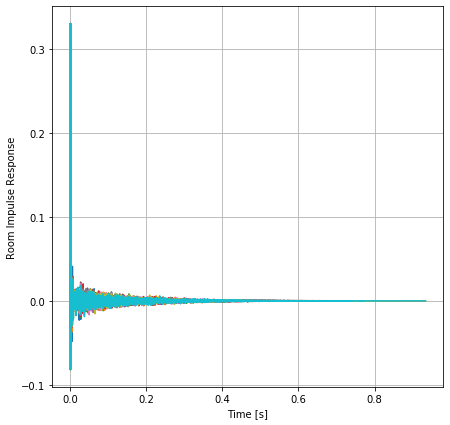

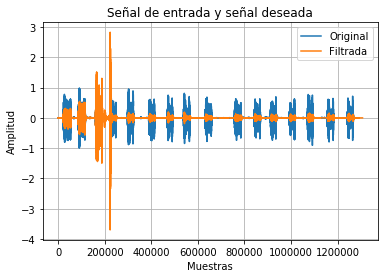

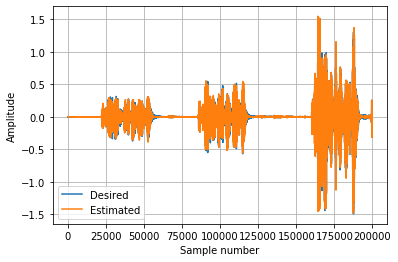

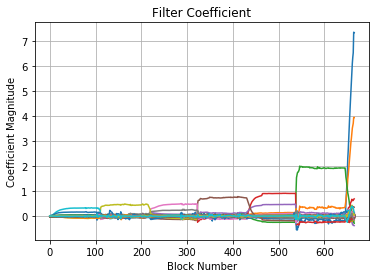

El valor máximo de error cuadrático es 0.3850729665905111
Tardó  6.592146873474121  segundos
Iteración Nº 1
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.5017083131110376, 1.1080242855640692, 1.75]
Se terminó en [2.7517083131110374, 1.1080242855640692, 1.75]


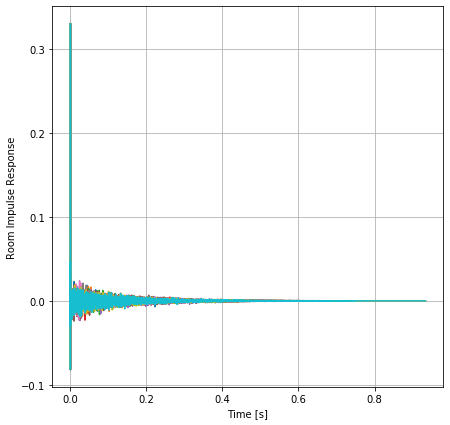

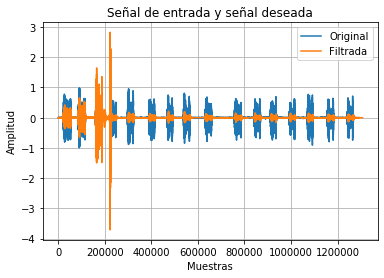

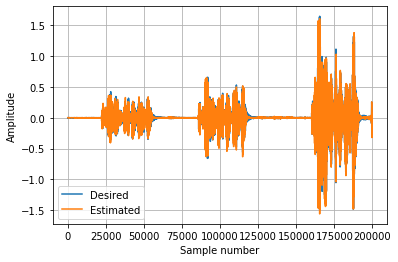

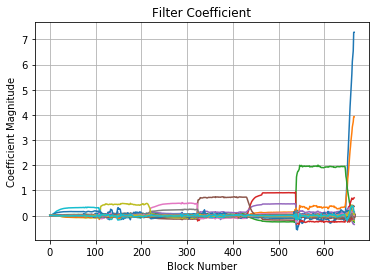

El valor máximo de error cuadrático es 0.41801581047568753
Tardó  6.461628437042236  segundos
Iteración Nº 2
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.9906788709699966, 0.8702913669778369, 1.75]
Se terminó en [2.2406788709699965, 0.8702913669778369, 1.75]


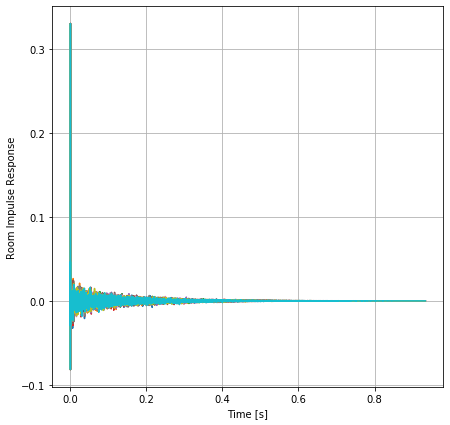

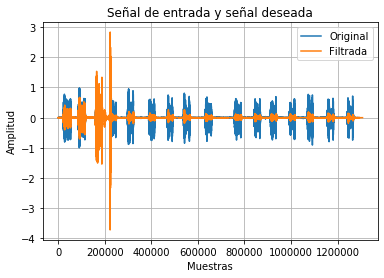

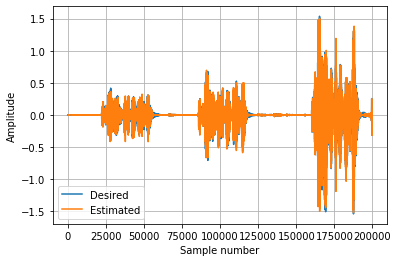

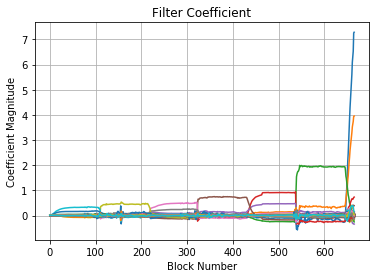

El valor máximo de error cuadrático es 0.435822502236708
Tardó  6.44443416595459  segundos
Iteración Nº 3
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.2755723650289157, 0.899760501080026, 1.75]
Se terminó en [2.525572365028916, 0.899760501080026, 1.75]


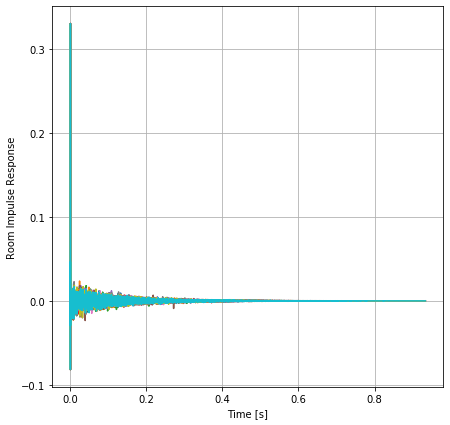

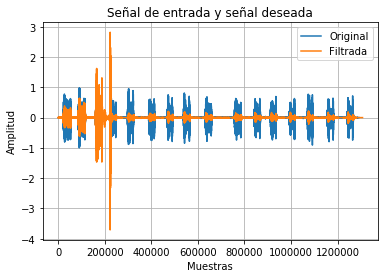

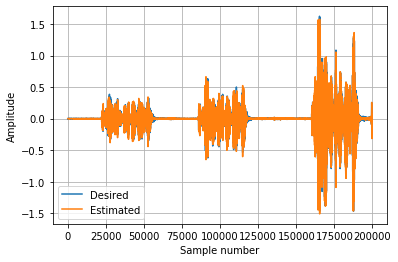

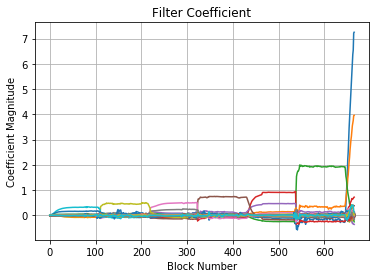

El valor máximo de error cuadrático es 0.43139676228164137
Tardó  6.52450966835022  segundos
Iteración Nº 4
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.40064738240026104, 0.7302389184788893, 1.75]
Se terminó en [1.650647382400261, 0.7302389184788893, 1.75]


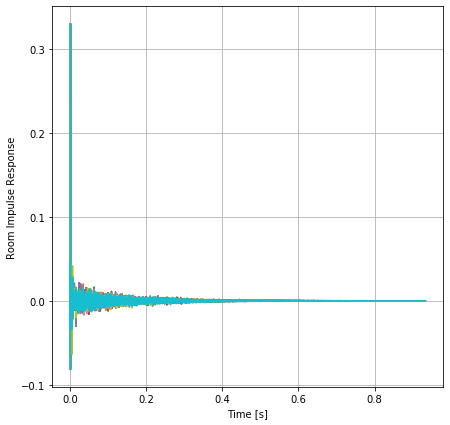

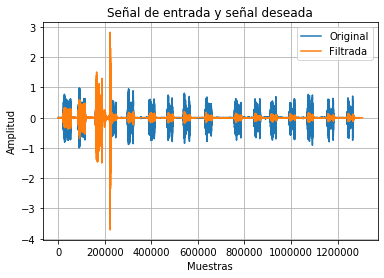

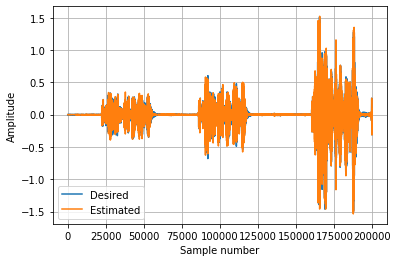

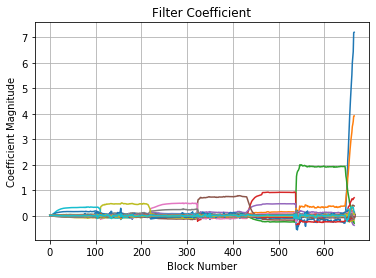

El valor máximo de error cuadrático es 0.36652974805283883
Tardó  6.399759292602539  segundos
Iteración Nº 5
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.5103913941687024, 3.841619806421941, 1.75]
Se terminó en [2.7603913941687024, 3.841619806421941, 1.75]


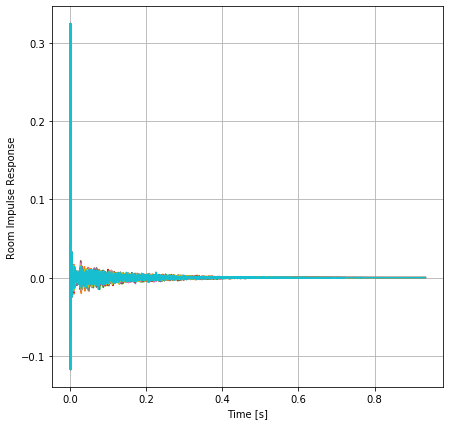

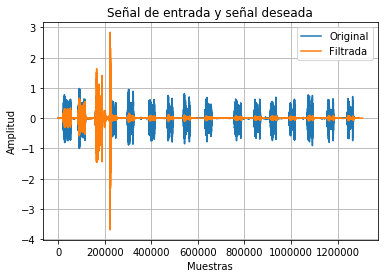

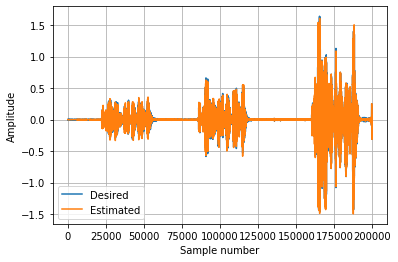

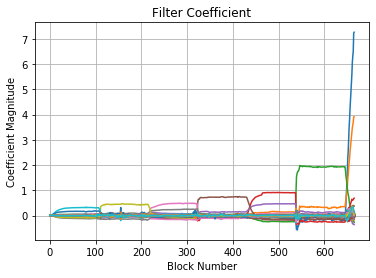

El valor máximo de error cuadrático es 0.38901196898811896
Tardó  6.361967325210571  segundos
Iteración Nº 6
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.20742940202424984, 2.621522257719822, 1.75]
Se terminó en [1.4574294020242498, 2.621522257719822, 1.75]


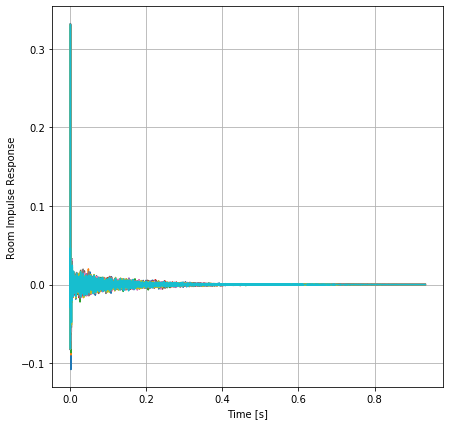

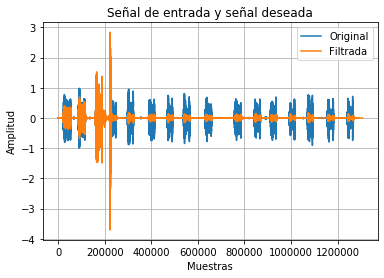

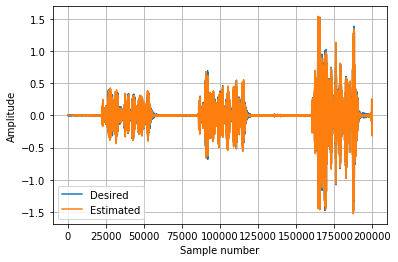

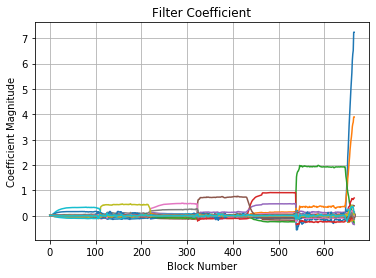

El valor máximo de error cuadrático es 0.37331372644627203
Tardó  6.507642984390259  segundos
Iteración Nº 7
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.24168365867857153, 1.6157505129864282, 1.75]
Se terminó en [1.4916836586785716, 1.6157505129864282, 1.75]


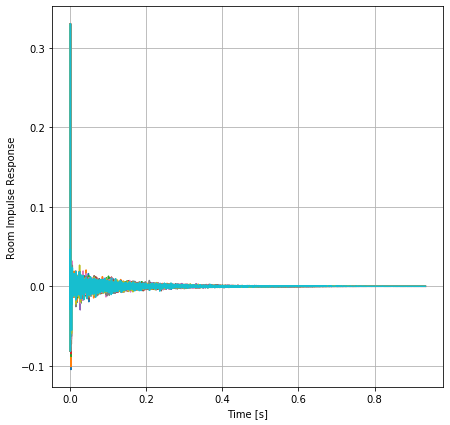

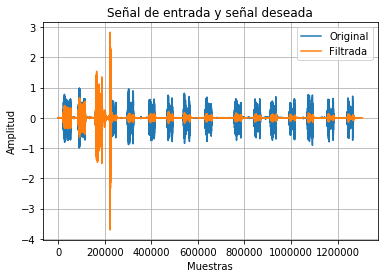

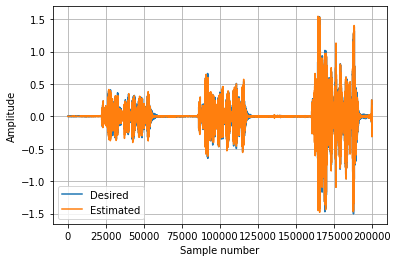

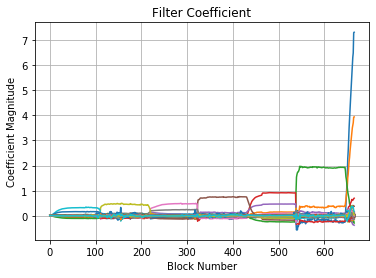

El valor máximo de error cuadrático es 0.4031382995753796
Tardó  6.36933708190918  segundos
Iteración Nº 8
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.18751849559572445, 0.8651713244382555, 1.75]
Se terminó en [1.4375184955957245, 0.8651713244382555, 1.75]


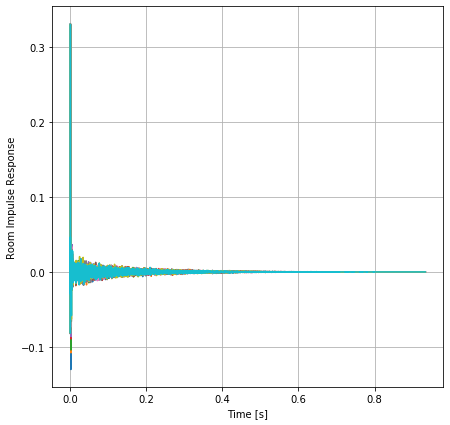

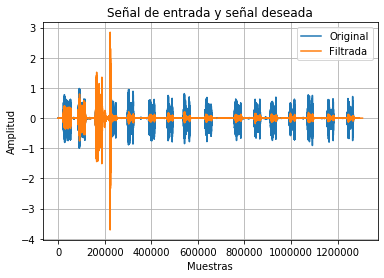

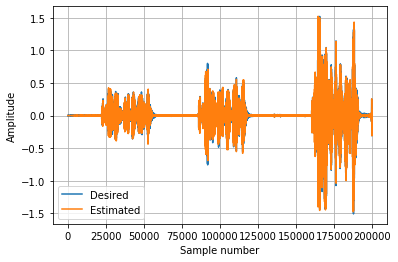

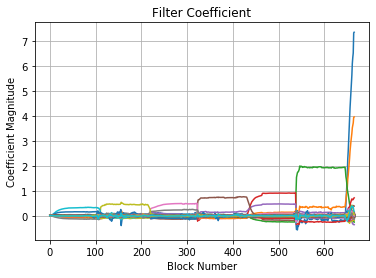

El valor máximo de error cuadrático es 0.4247600772457274
Tardó  6.439278841018677  segundos
Iteración Nº 9
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.3198253555109054, 1.8713208324781556, 1.75]
Se terminó en [2.5698253555109054, 1.8713208324781556, 1.75]


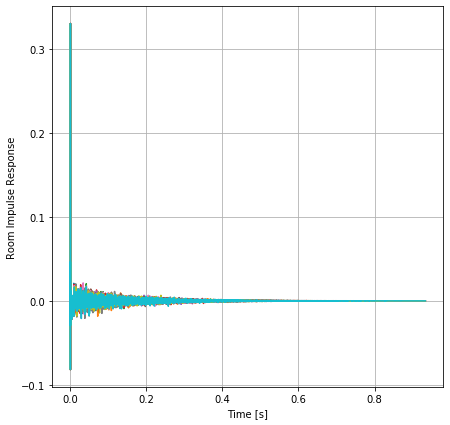

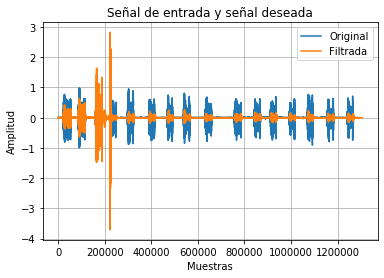

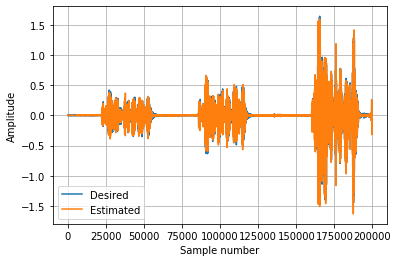

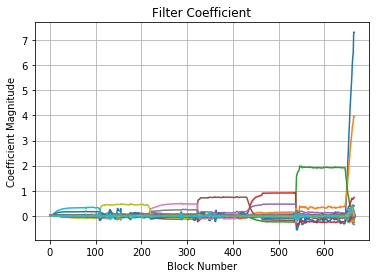

El valor máximo de error cuadrático es 0.3462686806281677
Tardó  6.4574644565582275  segundos
Iteración Nº 10
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.2798450040026799, 3.819261831077788, 1.75]
Se terminó en [2.52984500400268, 3.819261831077788, 1.75]


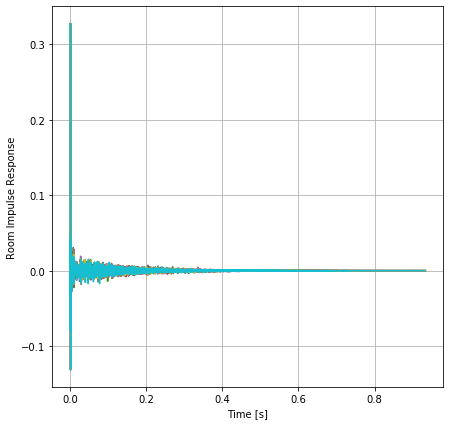

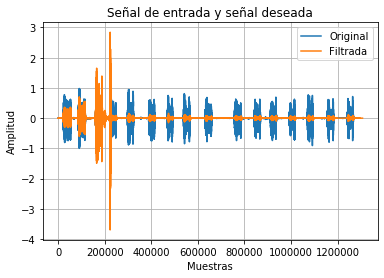

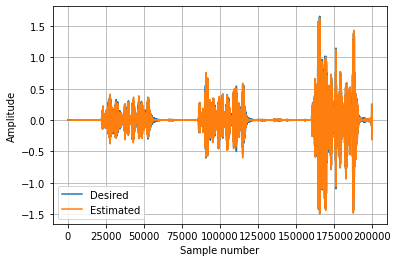

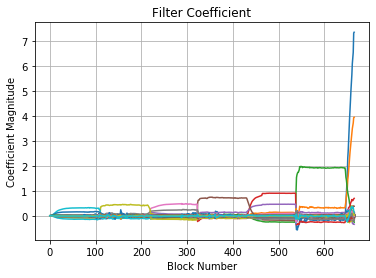

El valor máximo de error cuadrático es 0.4082988288520576
Tardó  6.337103843688965  segundos
Iteración Nº 11
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.18130548980676847, 1.2619747241877612, 1.75]
Se terminó en [1.4313054898067685, 1.2619747241877612, 1.75]


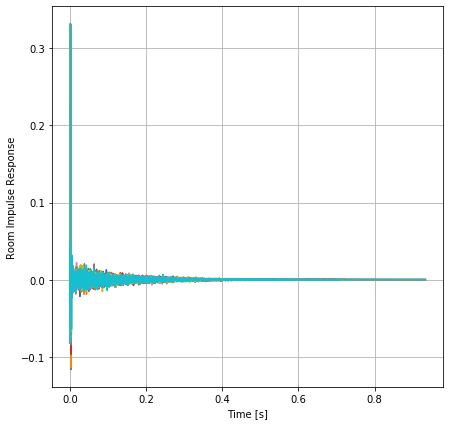

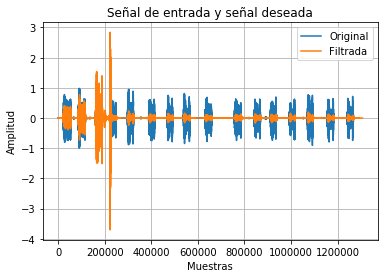

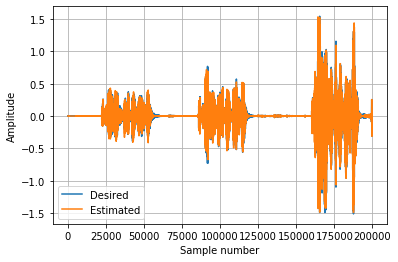

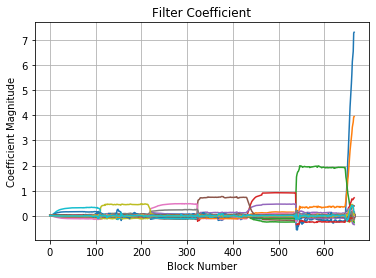

El valor máximo de error cuadrático es 0.38357294713655504
Tardó  6.373920917510986  segundos
Iteración Nº 12
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.4054249398248635, 1.5879564555613292, 1.75]
Se terminó en [2.6554249398248633, 1.5879564555613292, 1.75]


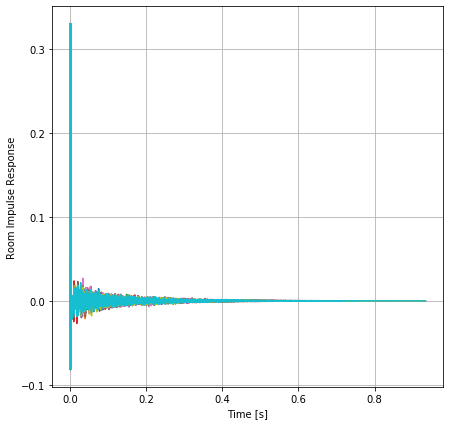

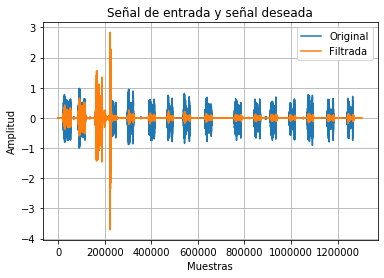

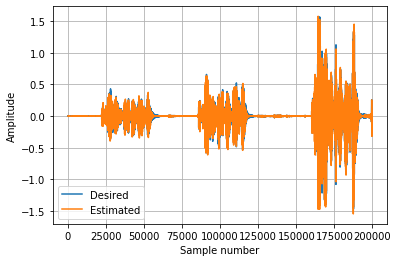

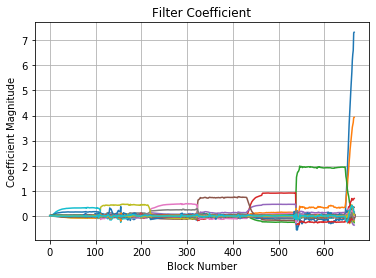

El valor máximo de error cuadrático es 0.3915825514212224
Tardó  6.640735864639282  segundos
Iteración Nº 13
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.9820020988748377, 1.0219909869228627, 1.75]
Se terminó en [2.2320020988748377, 1.0219909869228627, 1.75]


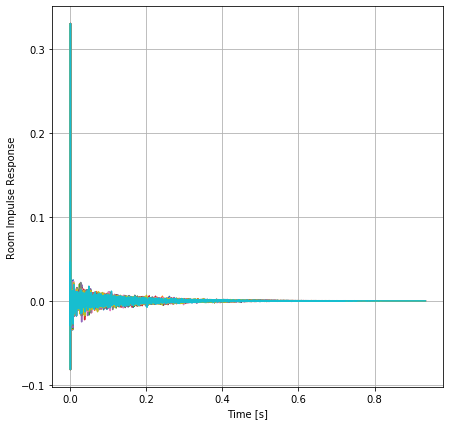

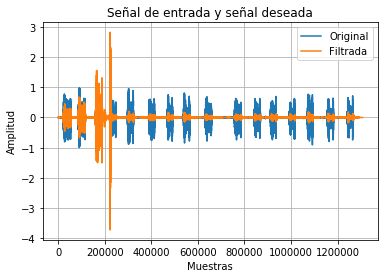

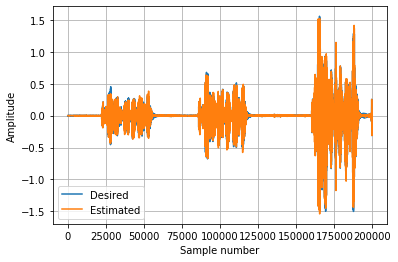

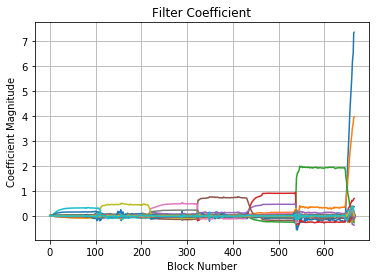

El valor máximo de error cuadrático es 0.44303743856683214
Tardó  6.476783752441406  segundos
Iteración Nº 14
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.5280945347781978, 0.20603405759807414, 1.75]
Se terminó en [2.778094534778198, 0.20603405759807414, 1.75]


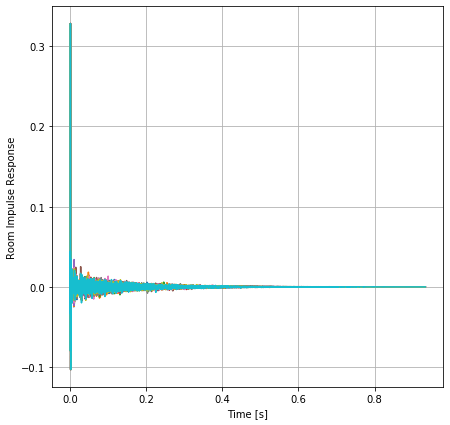

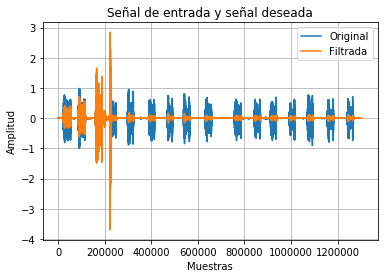

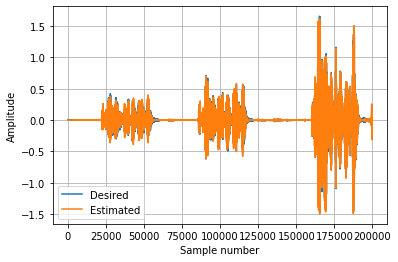

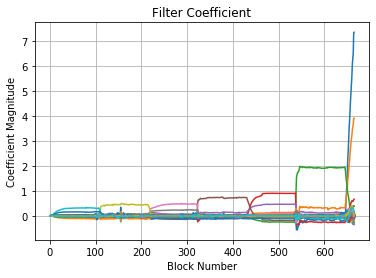

El valor máximo de error cuadrático es 0.38591555234849195
Tardó  6.2947986125946045  segundos
Iteración Nº 15
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.4545777031405316, 1.778315588922974, 1.75]
Se terminó en [2.7045777031405316, 1.778315588922974, 1.75]


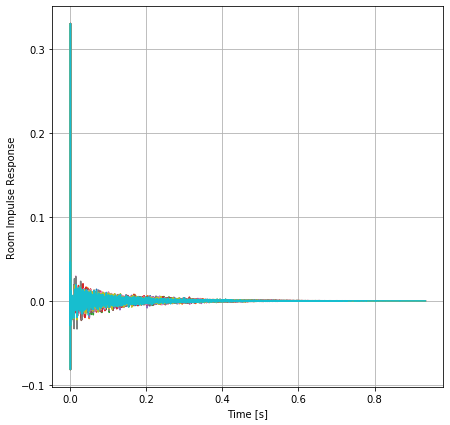

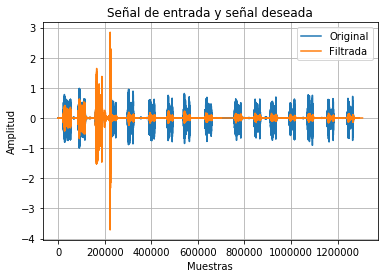

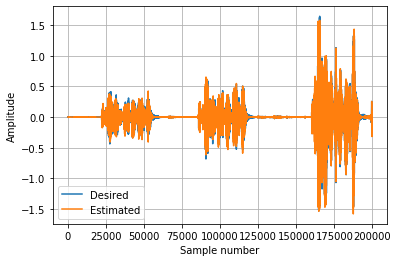

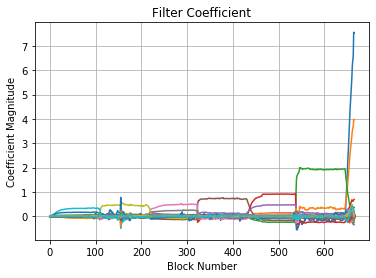

El valor máximo de error cuadrático es 0.3702663018027072
Tardó  6.542707204818726  segundos
Iteración Nº 16
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.12182504256108118, 1.8170617524237946, 1.75]
Se terminó en [1.3718250425610812, 1.8170617524237946, 1.75]


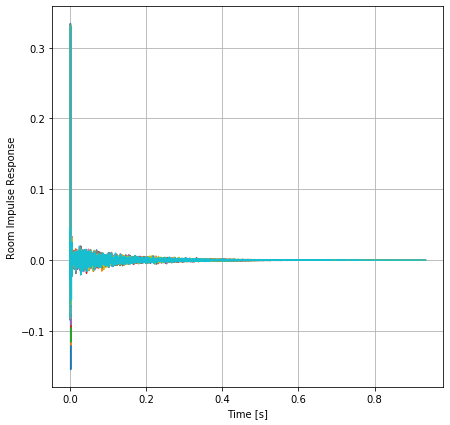

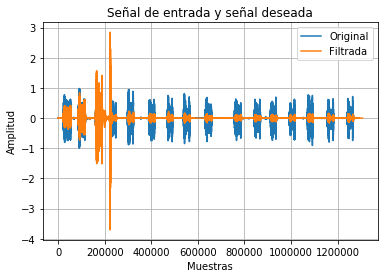

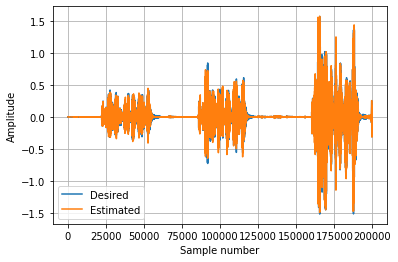

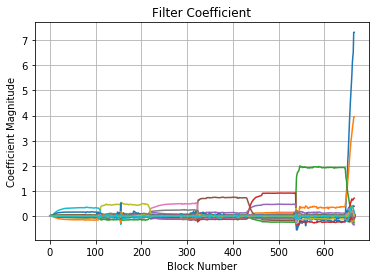

El valor máximo de error cuadrático es 0.35794214215079073
Tardó  6.388657808303833  segundos
Iteración Nº 17
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.299854981400509, 3.8191095659976217, 1.75]
Se terminó en [1.549854981400509, 3.8191095659976217, 1.75]


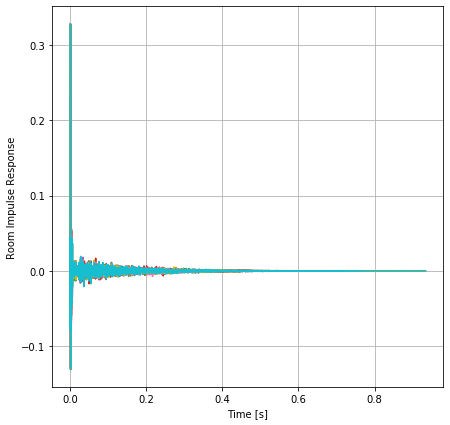

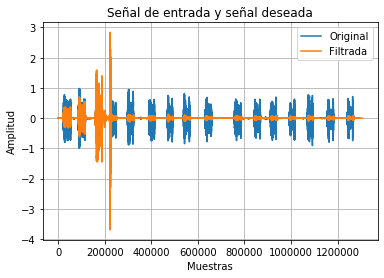

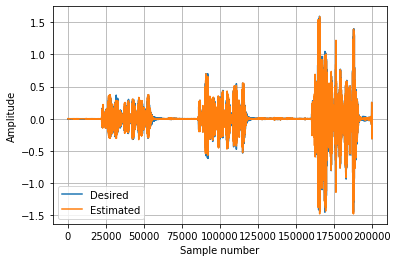

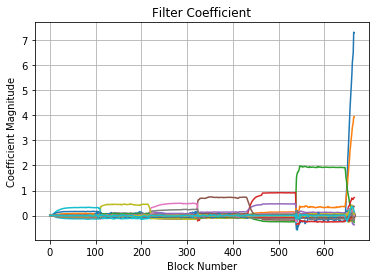

El valor máximo de error cuadrático es 0.39362366834800777
Tardó  6.411702632904053  segundos
Iteración Nº 18
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.4794287206434125, 3.163343245079462, 1.75]
Se terminó en [2.7294287206434125, 3.163343245079462, 1.75]


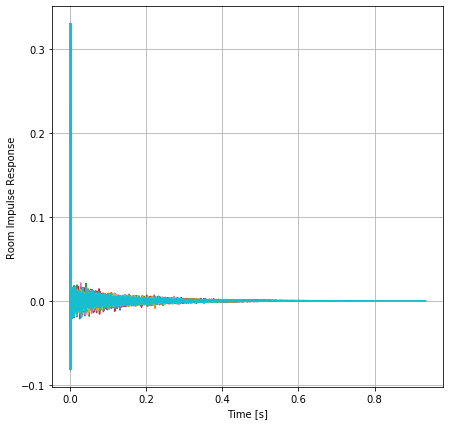

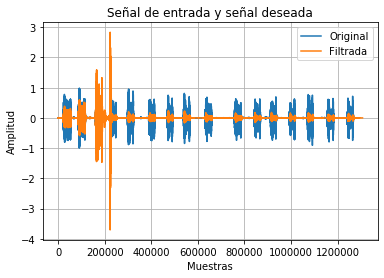

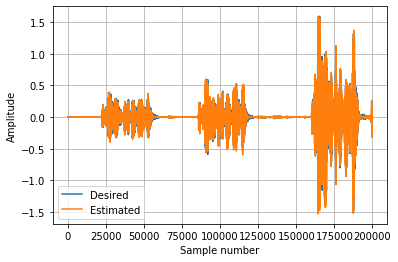

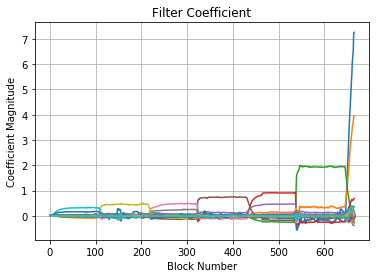

El valor máximo de error cuadrático es 0.3932501034122153
Tardó  6.457150220870972  segundos
Iteración Nº 19
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.2293685559479905, 2.065408239365725, 1.75]
Se terminó en [2.4793685559479908, 2.065408239365725, 1.75]


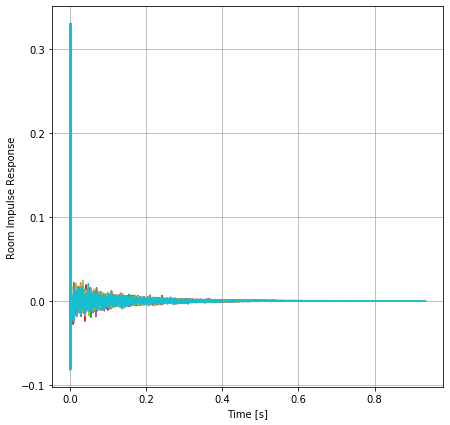

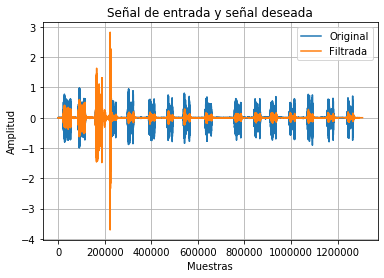

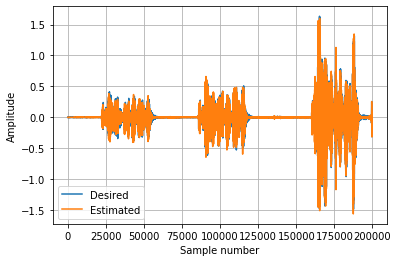

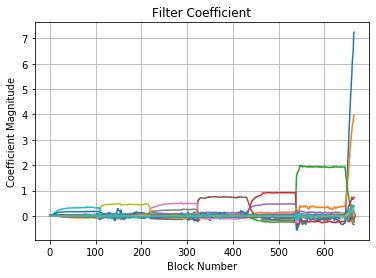

El valor máximo de error cuadrático es 0.35001432664354004
Tardó  6.3677239418029785  segundos
Iteración Nº 20
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.0322631482795148, 3.464521247821978, 1.75]
Se terminó en [2.282263148279515, 3.464521247821978, 1.75]


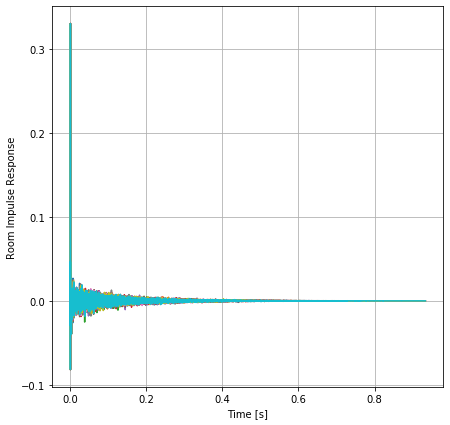

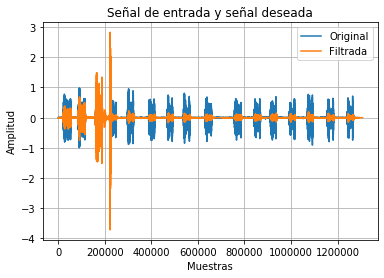

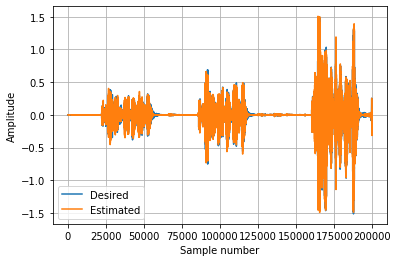

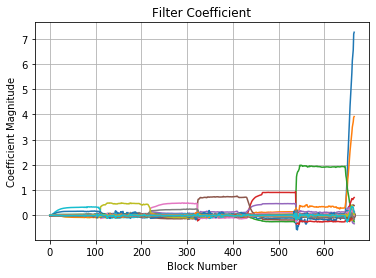

El valor máximo de error cuadrático es 0.38617951953917706
Tardó  6.379647731781006  segundos
Iteración Nº 21
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.8319296372187032, 0.5010814674548607, 1.75]
Se terminó en [2.0819296372187033, 0.5010814674548607, 1.75]


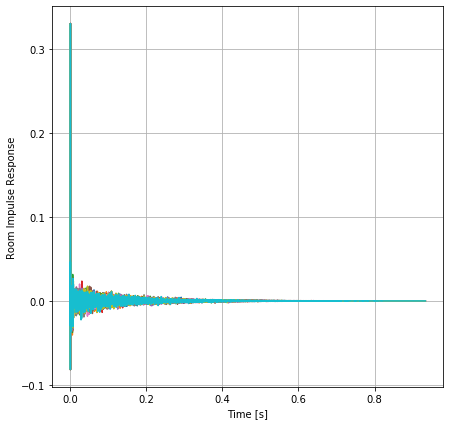

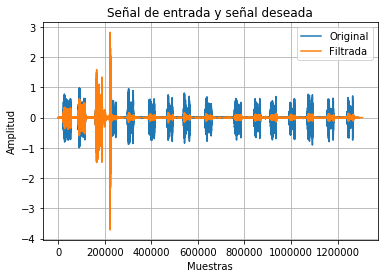

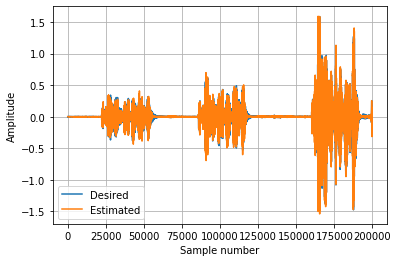

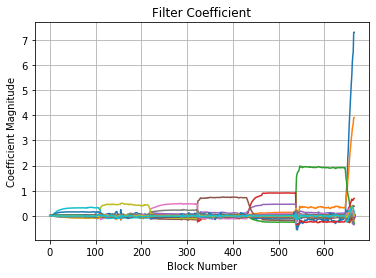

El valor máximo de error cuadrático es 0.4071868520109363
Tardó  6.47931694984436  segundos
Iteración Nº 22
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.42107668689126865, 2.8918103645602717, 1.75]
Se terminó en [1.6710766868912685, 2.8918103645602717, 1.75]


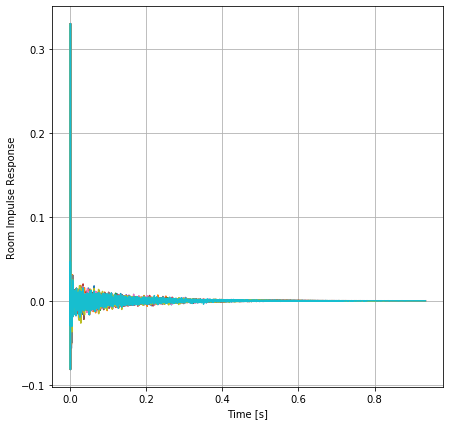

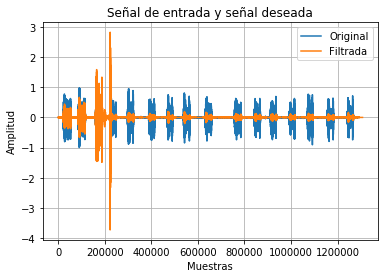

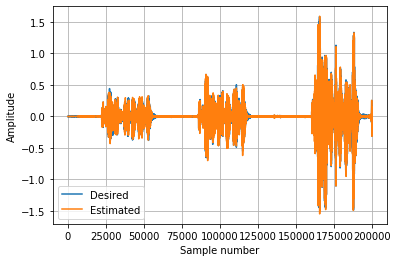

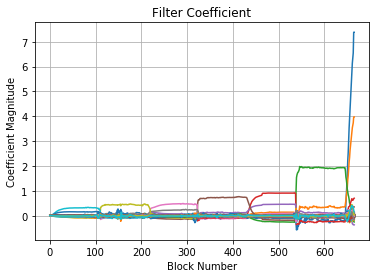

El valor máximo de error cuadrático es 0.3866970941210723
Tardó  6.484986066818237  segundos
Iteración Nº 23
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.6979232738855479, 3.4121660420996798, 1.75]
Se terminó en [1.9479232738855479, 3.4121660420996798, 1.75]


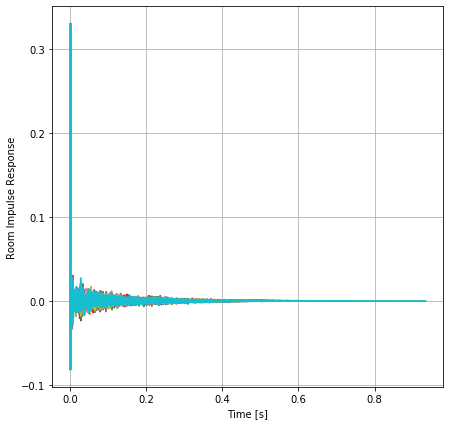

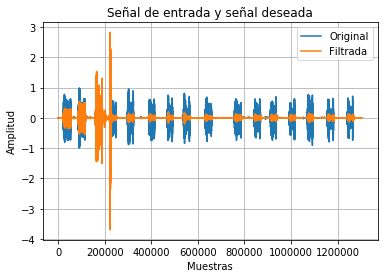

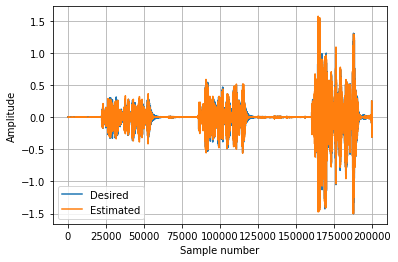

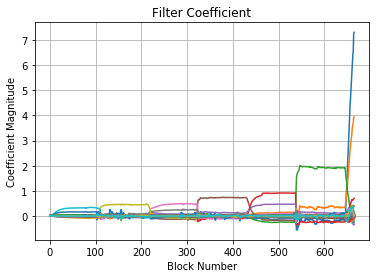

El valor máximo de error cuadrático es 0.40632315136101177
Tardó  6.419023036956787  segundos
Iteración Nº 24
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.49827542391167434, 0.903101958682822, 1.75]
Se terminó en [1.7482754239116742, 0.903101958682822, 1.75]


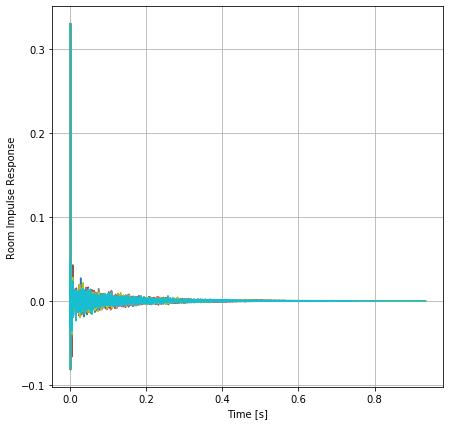

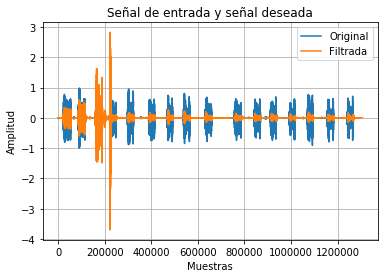

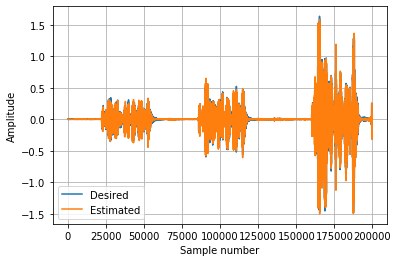

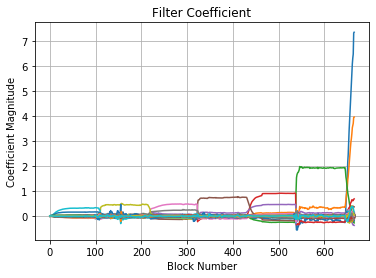

El valor máximo de error cuadrático es 0.3765715880180939
Tardó  6.542232036590576  segundos
Iteración Nº 25
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.6209642325479846, 1.913781443508766, 1.75]
Se terminó en [1.8709642325479847, 1.913781443508766, 1.75]


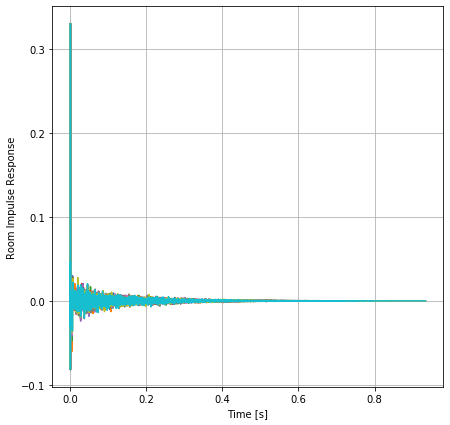

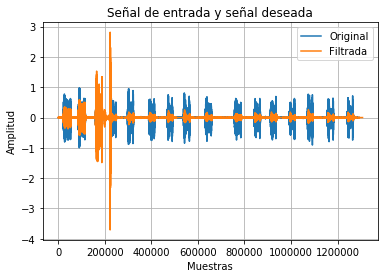

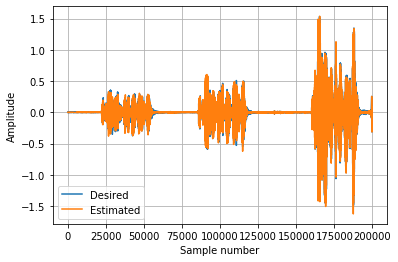

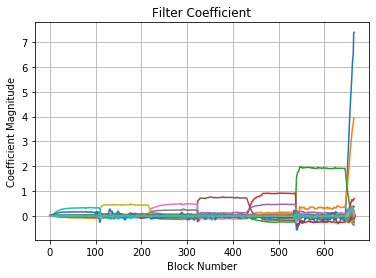

El valor máximo de error cuadrático es 0.35716393229880206
Tardó  6.243088722229004  segundos
Iteración Nº 26
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.3164398893998832, 1.0585686473198153, 1.75]
Se terminó en [2.5664398893998834, 1.0585686473198153, 1.75]


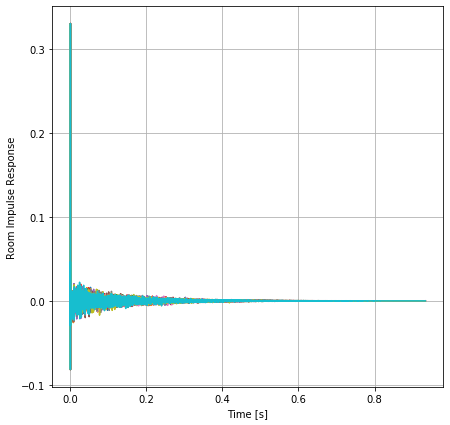

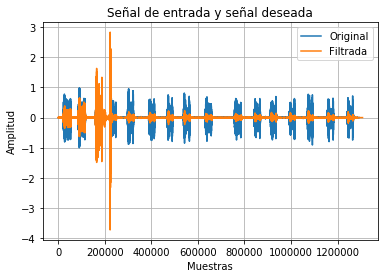

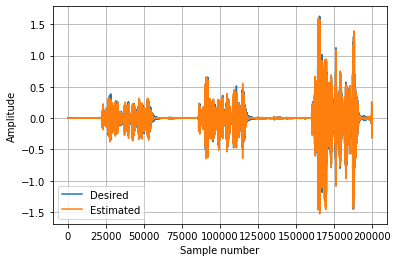

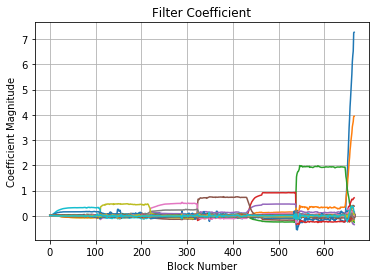

El valor máximo de error cuadrático es 0.37375722576659665
Tardó  6.451952934265137  segundos
Iteración Nº 27
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.468533095032559, 0.20007955378847164, 1.75]
Se terminó en [2.718533095032559, 0.20007955378847164, 1.75]


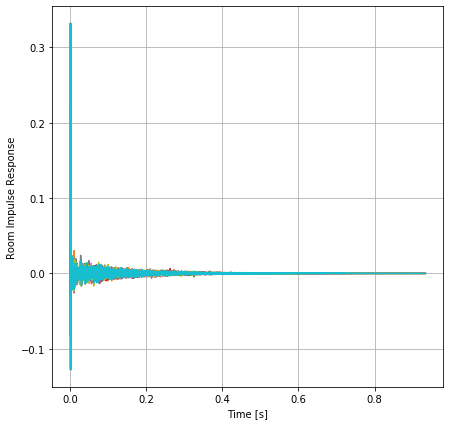

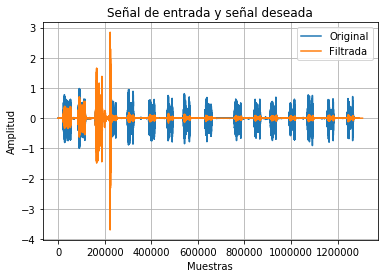

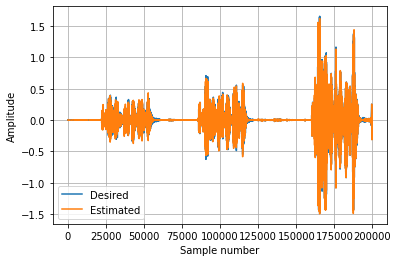

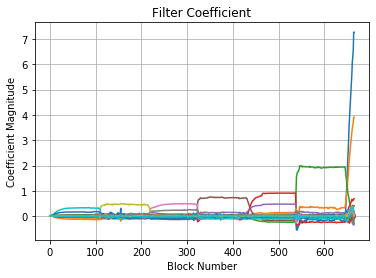

El valor máximo de error cuadrático es 0.38809972451122077
Tardó  6.494603395462036  segundos
Iteración Nº 28
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.030193343755834, 1.178267738106117, 1.75]
Se terminó en [2.280193343755834, 1.178267738106117, 1.75]


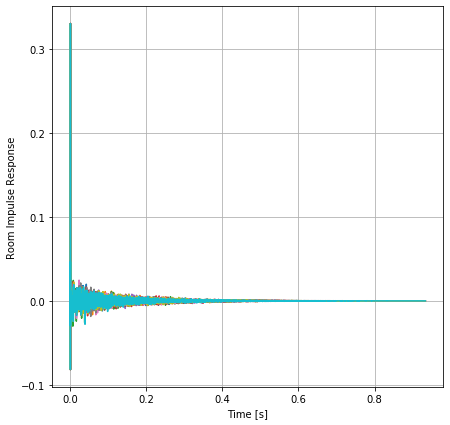

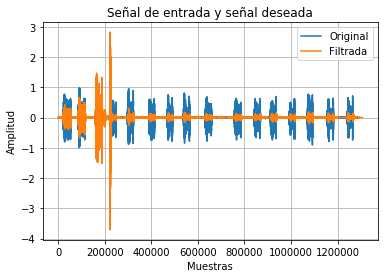

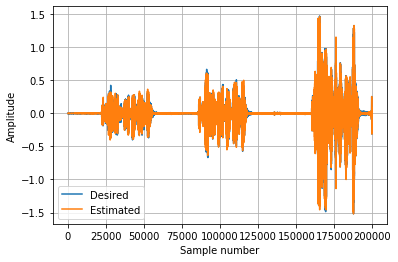

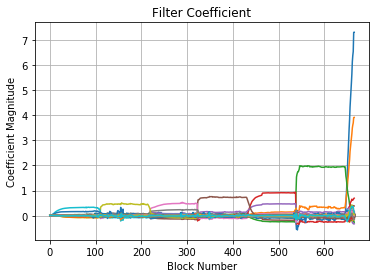

El valor máximo de error cuadrático es 0.42593752398638
Tardó  6.413458824157715  segundos
Iteración Nº 29
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.2608517343042327, 0.9180619363094533, 1.75]
Se terminó en [2.5108517343042327, 0.9180619363094533, 1.75]


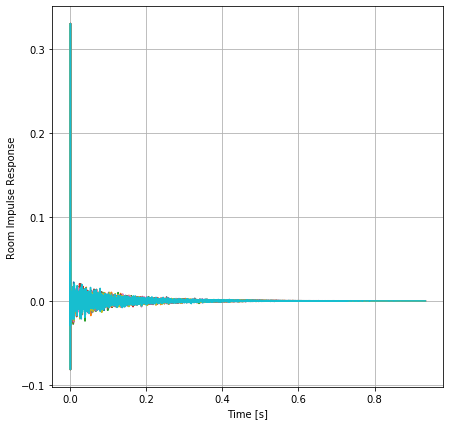

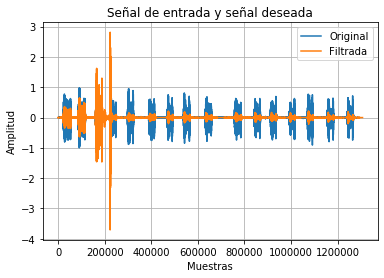

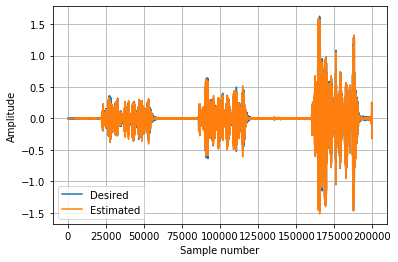

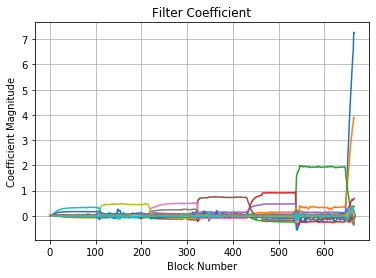

El valor máximo de error cuadrático es 0.37573457188883125
Tardó  6.369870901107788  segundos
Iteración Nº 30
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.8657360357338484, 3.7697981838256314, 1.75]
Se terminó en [2.1157360357338484, 3.7697981838256314, 1.75]


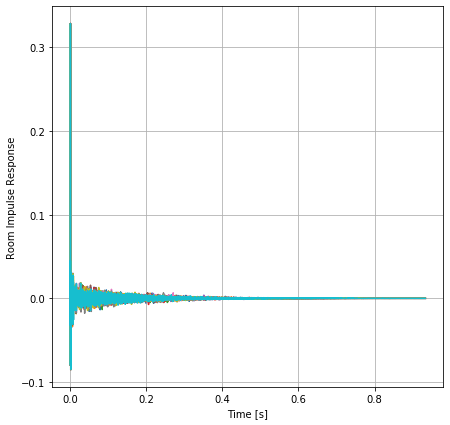

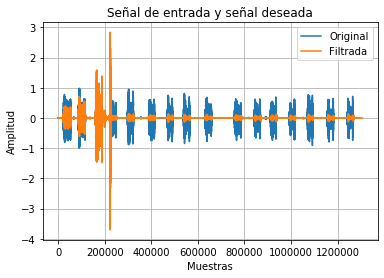

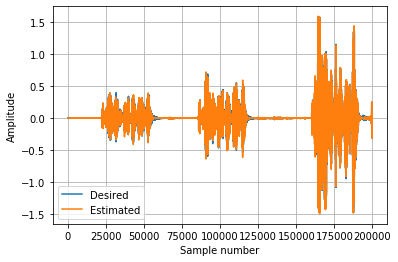

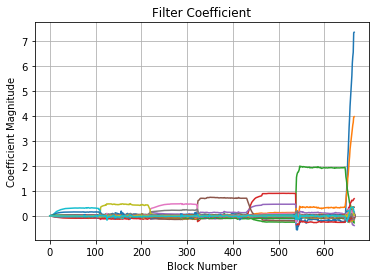

El valor máximo de error cuadrático es 0.38275890485612807
Tardó  6.446335315704346  segundos
Iteración Nº 31
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.045239507198393654, 2.052357803553673, 1.75]
Se terminó en [1.2952395071983938, 2.052357803553673, 1.75]


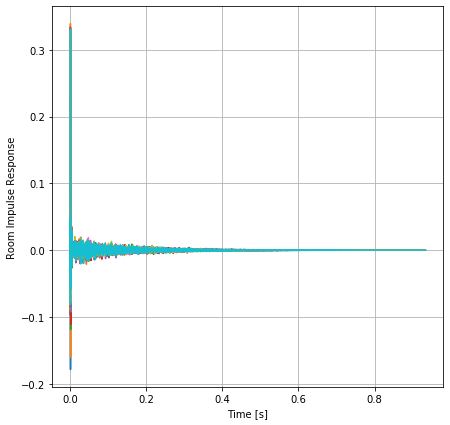

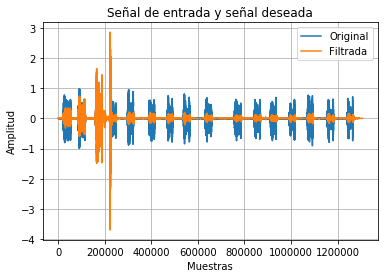

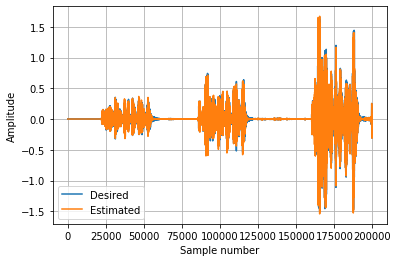

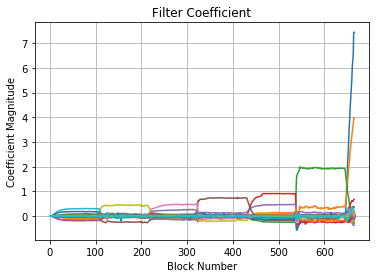

El valor máximo de error cuadrático es 0.3823127650985818
Tardó  6.394906520843506  segundos
Iteración Nº 32
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.9348132661618076, 3.582659861825245, 1.75]
Se terminó en [2.1848132661618074, 3.582659861825245, 1.75]


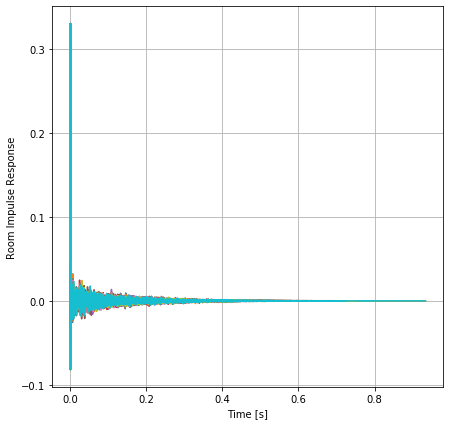

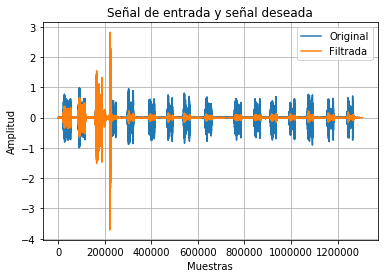

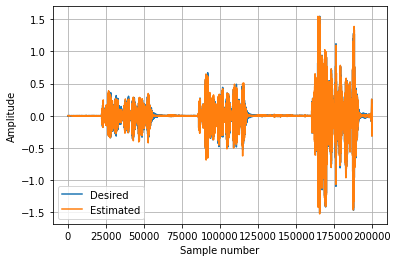

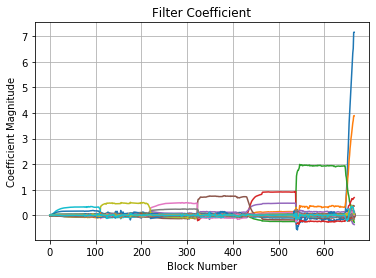

El valor máximo de error cuadrático es 0.43208264473604246
Tardó  6.419991970062256  segundos
Iteración Nº 33
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.9363860482342599, 2.702314045031854, 1.75]
Se terminó en [2.18638604823426, 2.702314045031854, 1.75]


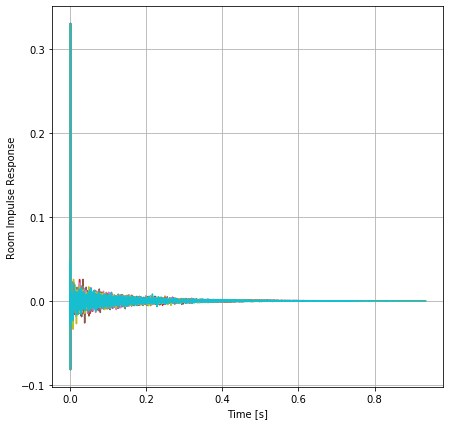

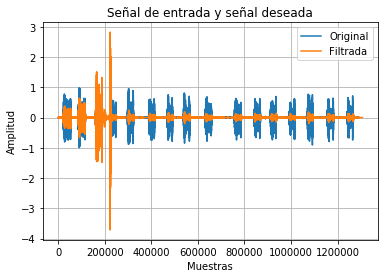

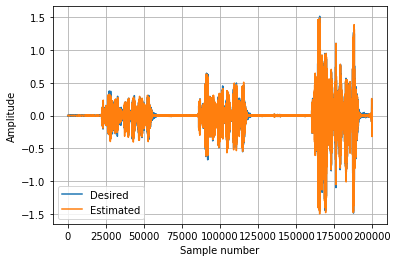

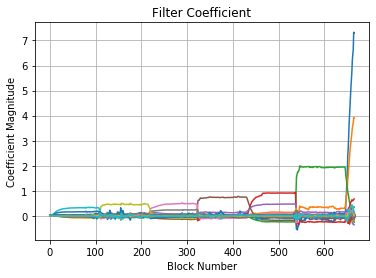

El valor máximo de error cuadrático es 0.42881560560225407
Tardó  6.501089096069336  segundos
Iteración Nº 34
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.3040712637091805, 1.913386087555872, 1.75]
Se terminó en [2.5540712637091803, 1.913386087555872, 1.75]


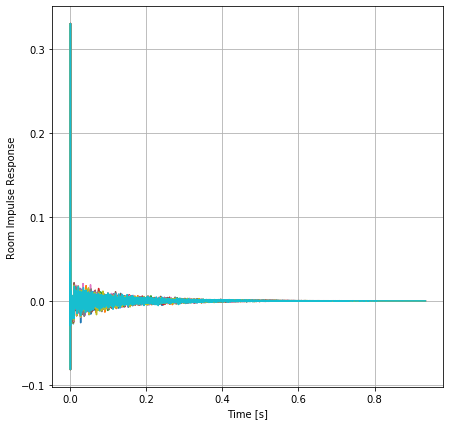

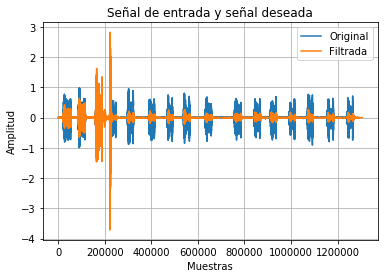

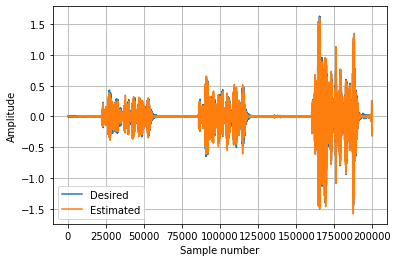

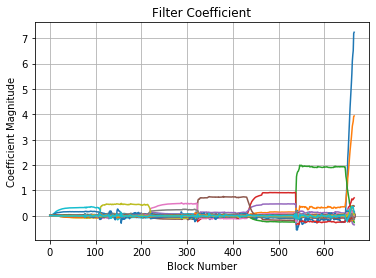

El valor máximo de error cuadrático es 0.3768124135636881
Tardó  6.360249042510986  segundos
Iteración Nº 35
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.5405087591228113, 0.8458035376188078, 1.75]
Se terminó en [2.7905087591228113, 0.8458035376188078, 1.75]


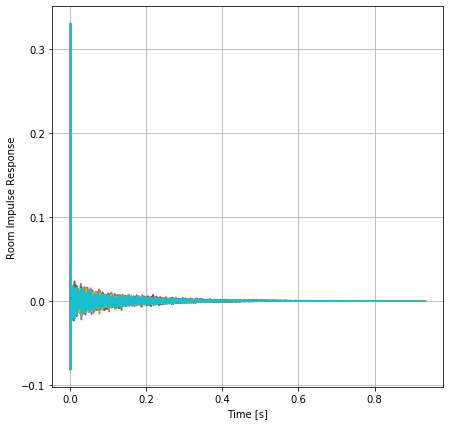

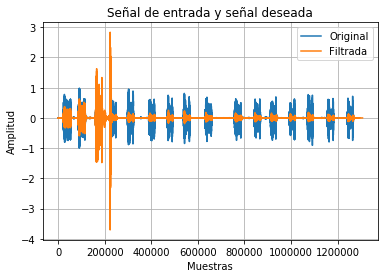

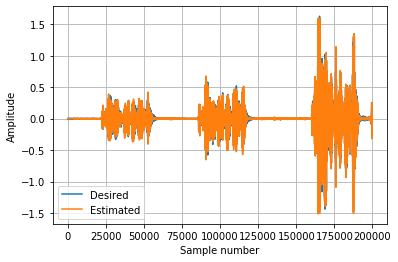

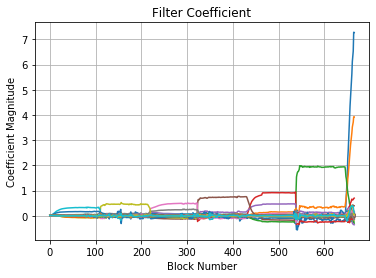

El valor máximo de error cuadrático es 0.3929266779317226
Tardó  6.386783123016357  segundos
Iteración Nº 36
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.6510586591622755, 2.6307117678863055, 1.75]
Se terminó en [1.9010586591622753, 2.6307117678863055, 1.75]


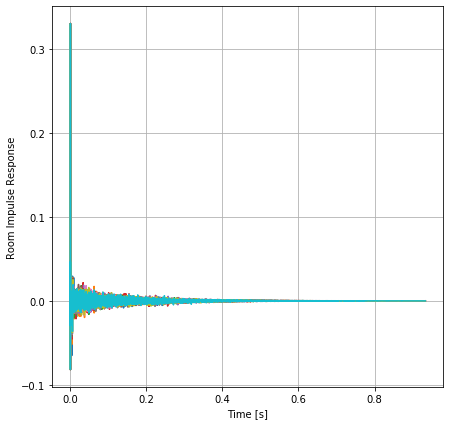

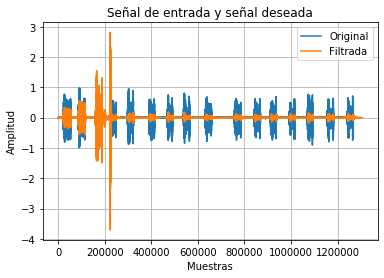

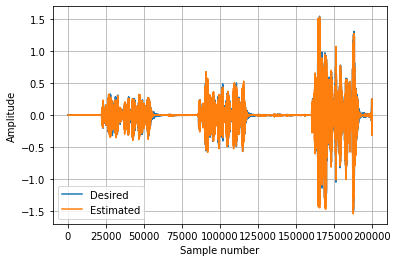

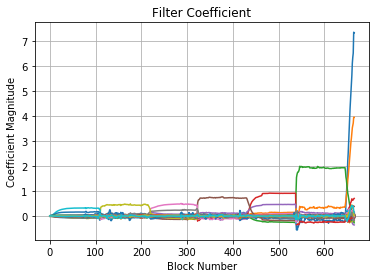

El valor máximo de error cuadrático es 0.42250984200958075
Tardó  6.424162149429321  segundos
Iteración Nº 37
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.29465414169949056, 3.6511386295839663, 1.75]
Se terminó en [1.5446541416994906, 3.6511386295839663, 1.75]


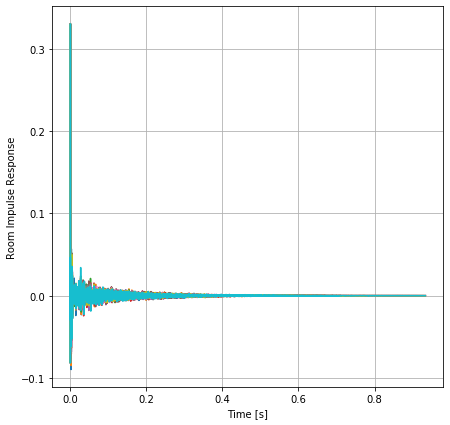

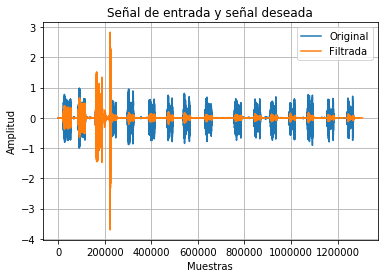

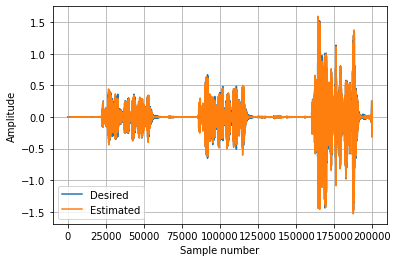

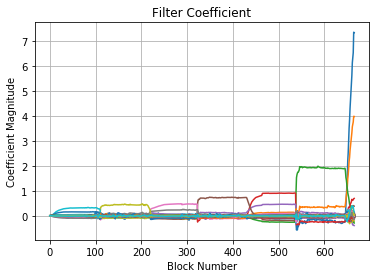

El valor máximo de error cuadrático es 0.36349146517245784
Tardó  6.359400510787964  segundos
Iteración Nº 38
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.3505061095369322, 2.5277317861139905, 1.75]
Se terminó en [1.6005061095369322, 2.5277317861139905, 1.75]


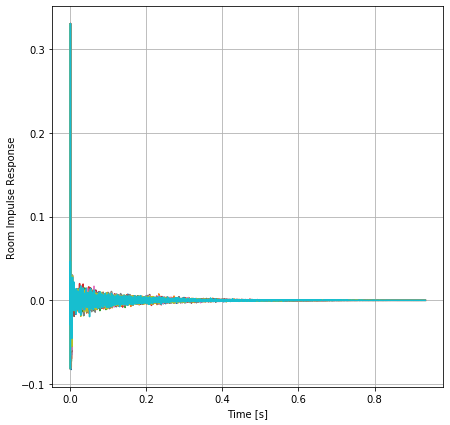

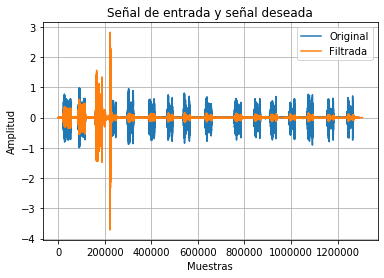

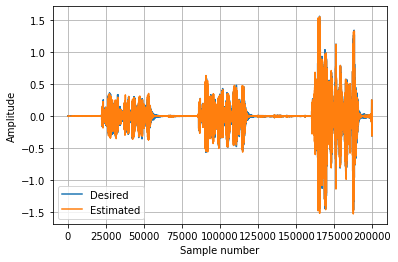

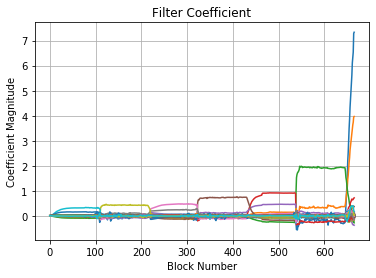

El valor máximo de error cuadrático es 0.37862225235052277
Tardó  6.3911919593811035  segundos
Iteración Nº 39
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.0087567058943838, 2.3958564658486567, 1.75]
Se terminó en [2.258756705894384, 2.3958564658486567, 1.75]


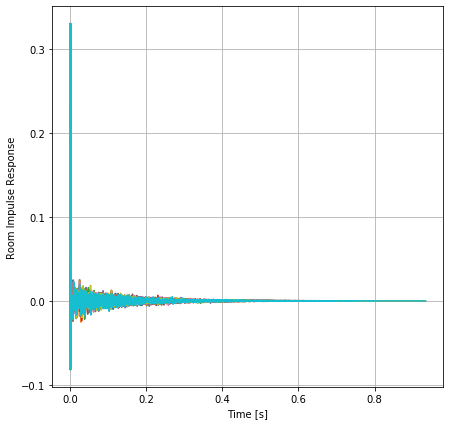

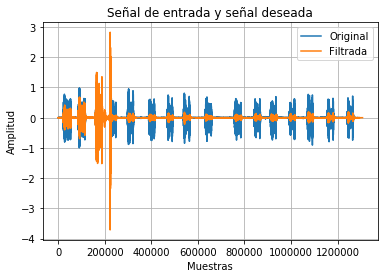

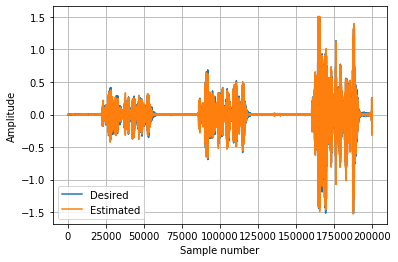

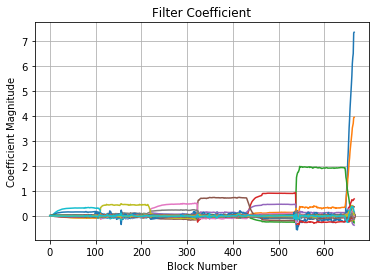

El valor máximo de error cuadrático es 0.41061874948754357
Tardó  6.455312728881836  segundos
Iteración Nº 40
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.49508106756936826, 0.3703642266305933, 1.75]
Se terminó en [1.7450810675693682, 0.3703642266305933, 1.75]


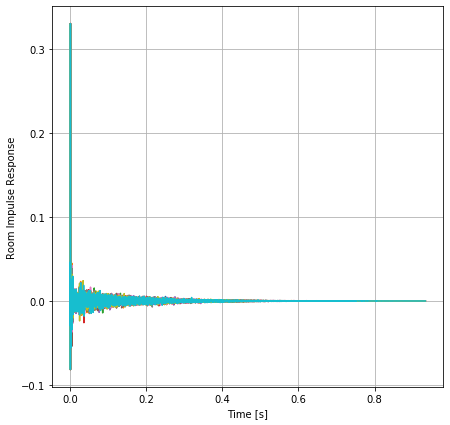

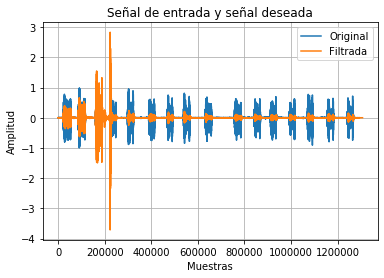

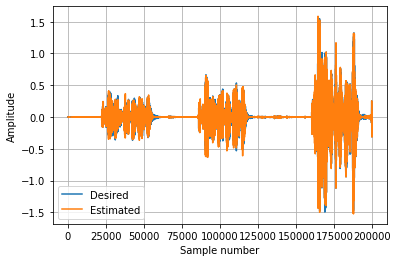

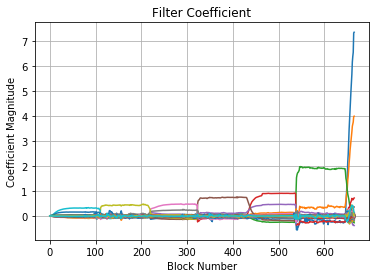

El valor máximo de error cuadrático es 0.38365715005715045
Tardó  6.378746509552002  segundos
Iteración Nº 41
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.7208261181554763, 3.415216865617752, 1.75]
Se terminó en [1.9708261181554763, 3.415216865617752, 1.75]


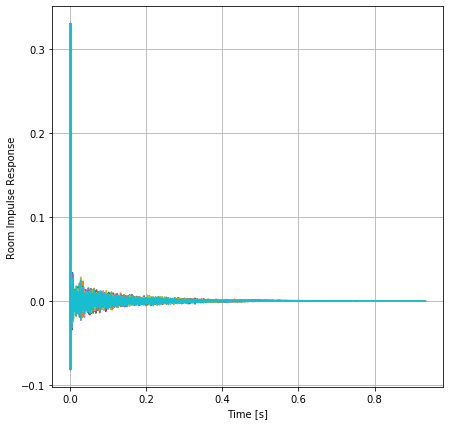

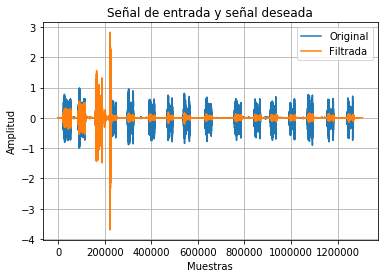

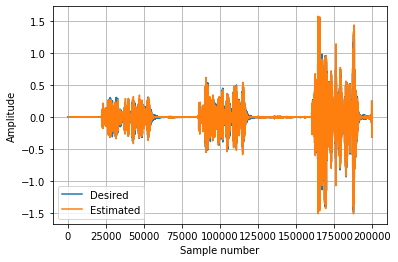

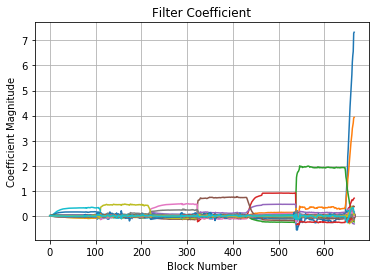

El valor máximo de error cuadrático es 0.36807419683847675
Tardó  6.517557382583618  segundos
Iteración Nº 42
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.4325249096890746, 3.8708329412655433, 1.75]
Se terminó en [2.6825249096890746, 3.8708329412655433, 1.75]


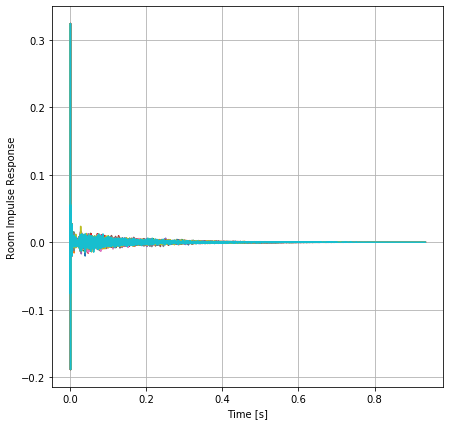

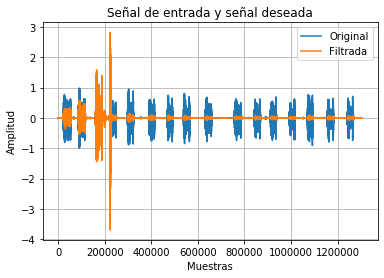

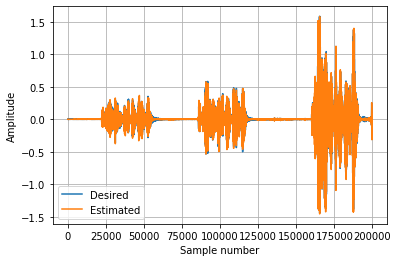

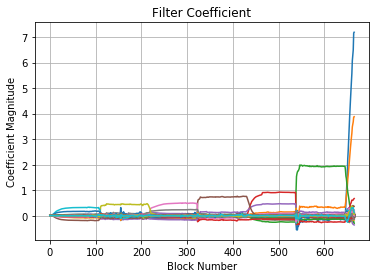

El valor máximo de error cuadrático es 0.3977006377033074
Tardó  6.486168622970581  segundos
Iteración Nº 43
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.2953110136219395, 0.6237944509741333, 1.75]
Se terminó en [2.5453110136219395, 0.6237944509741333, 1.75]


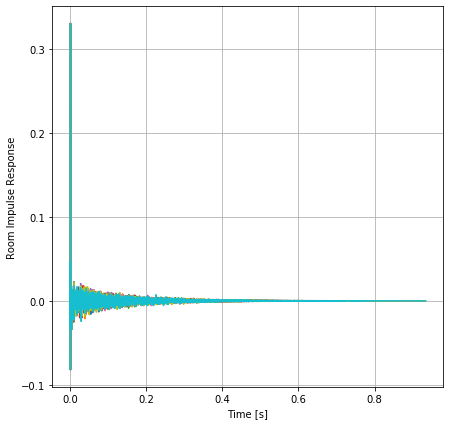

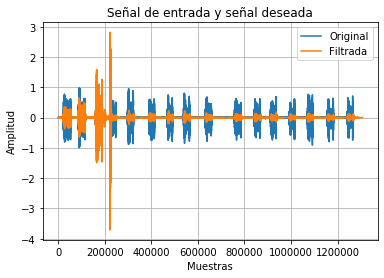

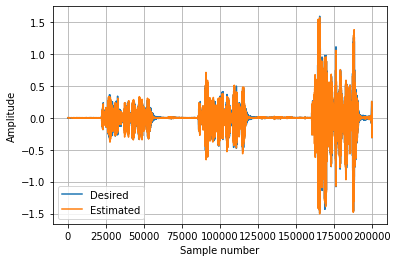

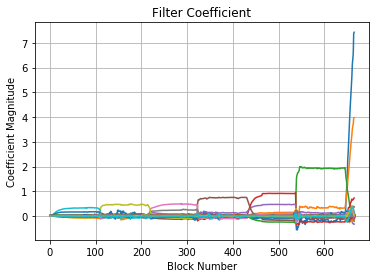

El valor máximo de error cuadrático es 0.3624473004128151
Tardó  6.3768393993377686  segundos
Iteración Nº 44
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.5204507761528386, 2.859999211173251, 1.75]
Se terminó en [1.7704507761528387, 2.859999211173251, 1.75]


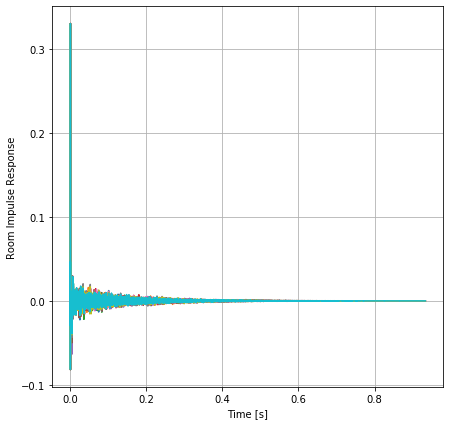

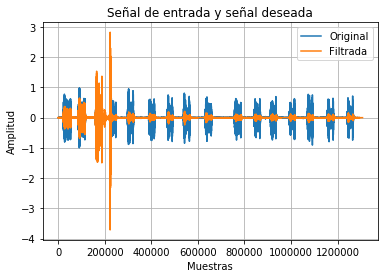

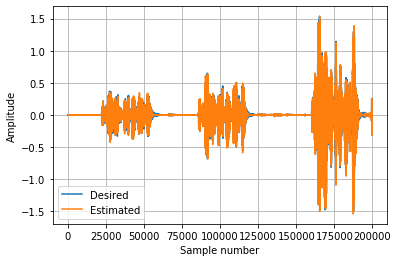

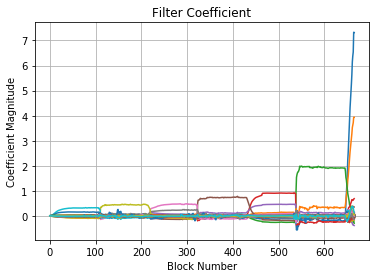

El valor máximo de error cuadrático es 0.3760692835996749
Tardó  6.406647205352783  segundos
Iteración Nº 45
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.626810755397917, 1.1156552950674503, 1.75]
Se terminó en [2.876810755397917, 1.1156552950674503, 1.75]


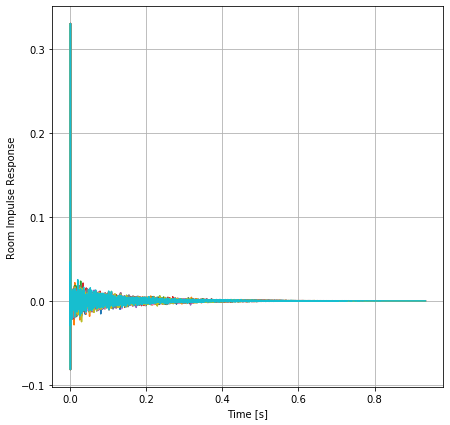

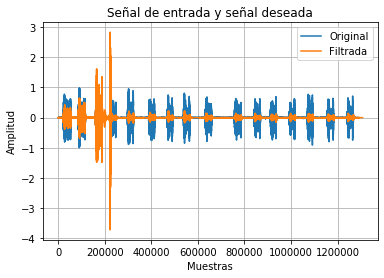

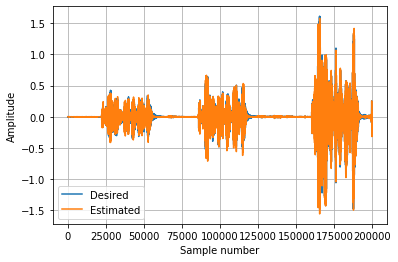

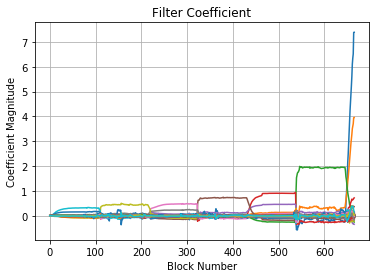

El valor máximo de error cuadrático es 0.4084200597186723
Tardó  6.476243019104004  segundos
Iteración Nº 46
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.49601089232475976, 0.2860302003509294, 1.75]
Se terminó en [1.7460108923247597, 0.2860302003509294, 1.75]


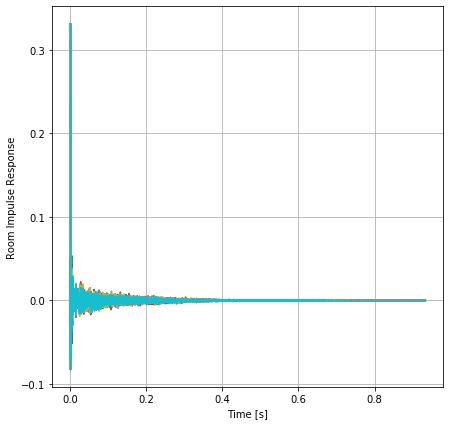

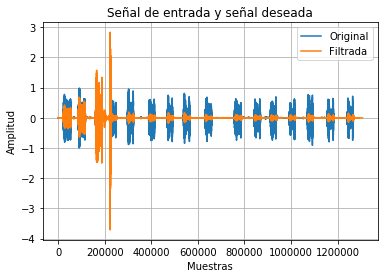

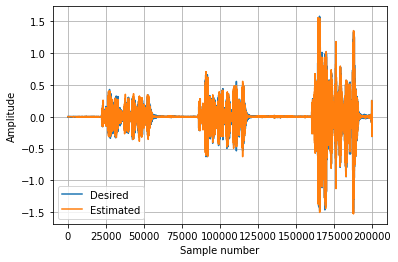

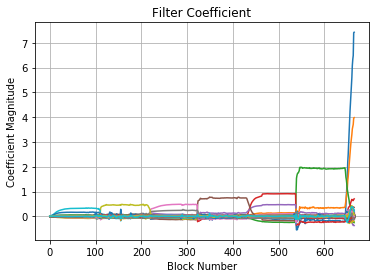

El valor máximo de error cuadrático es 0.3882908528246181
Tardó  6.337300539016724  segundos
Iteración Nº 47
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.7988063386498542, 0.1286813184887574, 1.75]
Se terminó en [2.0488063386498543, 0.1286813184887574, 1.75]


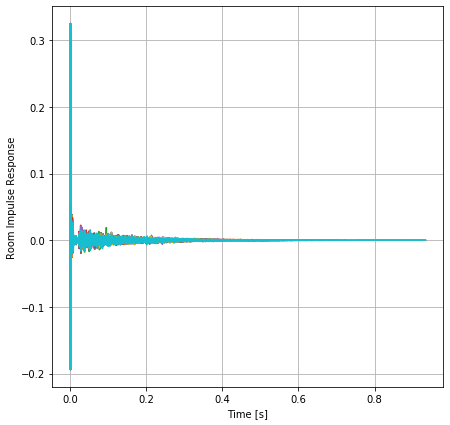

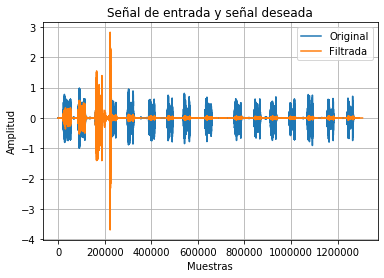

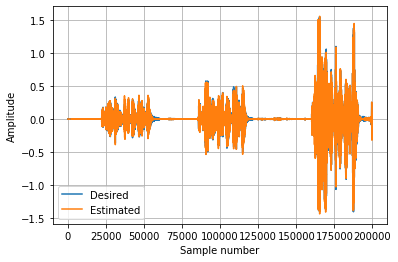

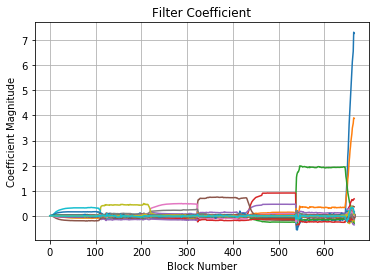

El valor máximo de error cuadrático es 0.37970746378492776
Tardó  6.235011100769043  segundos
Iteración Nº 48
La habitación es de 3.3   4   2.5  m
Se arrancó en [1.4955864180397846, 3.4918630305737, 1.75]
Se terminó en [2.7455864180397844, 3.4918630305737, 1.75]


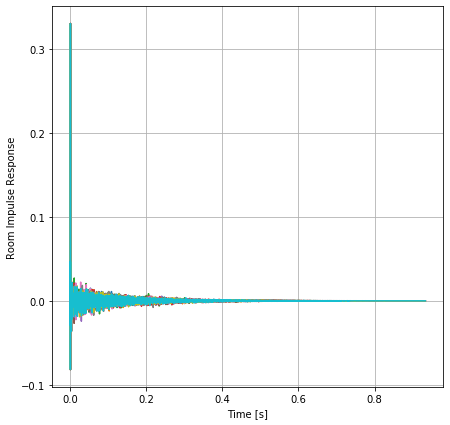

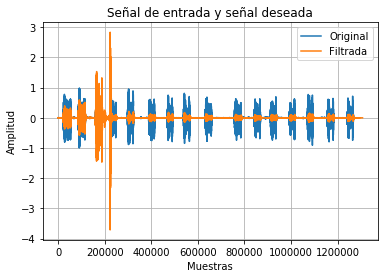

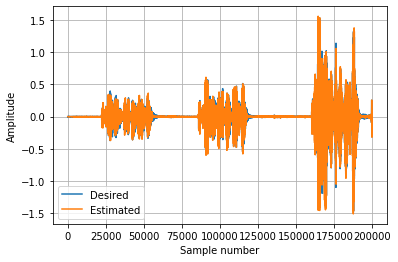

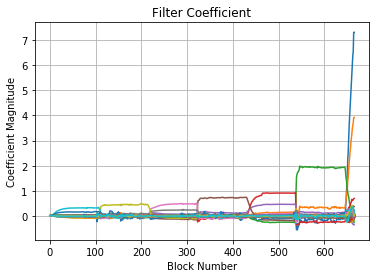

El valor máximo de error cuadrático es 0.36779366892635446
Tardó  6.4958765506744385  segundos
Iteración Nº 49
La habitación es de 3.3   4   2.5  m
Se arrancó en [0.6706522449097031, 1.0438370794684295, 1.75]
Se terminó en [1.9206522449097032, 1.0438370794684295, 1.75]


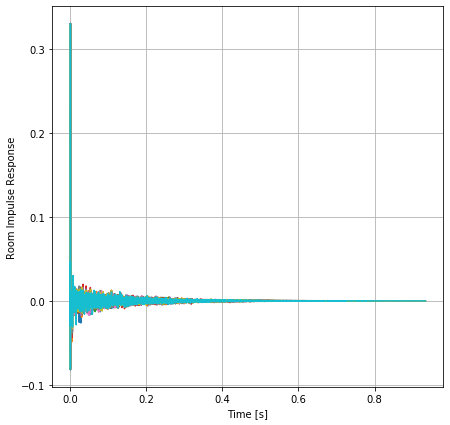

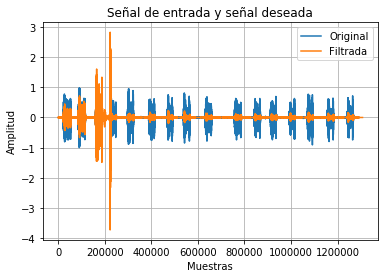

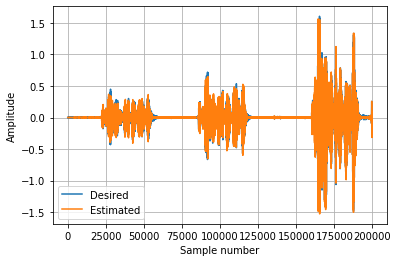

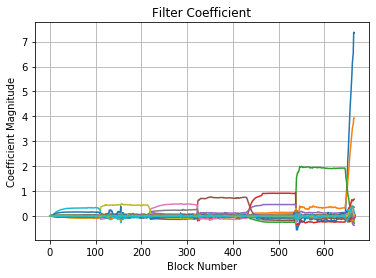

El valor máximo de error cuadrático es 0.42709100868971067
Tardó  6.338714838027954  segundos
Todas las simulaciones tardaron  321.34466075897217  segundos


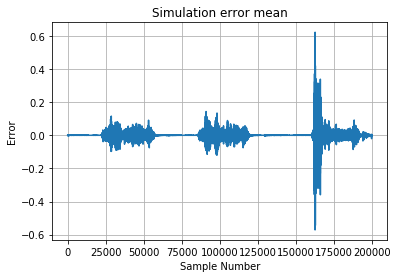

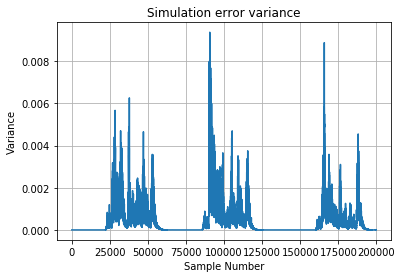

In [177]:
"""A filtered-reference Least-Mean-Square (FxLMS) filter."""

import numpy as np
import matplotlib.pyplot as plt
import time

from adafilt import FastBlockLMSFilter
from adafilt.io import FakeInterface
M = 300
length = M  # number of adaptive FIR filter taps
blocklength = M  # length of I/O buffer and blocksize of filter

test_len=200000

number_of_blocks =  test_len//M

test_time=test_len/fs

room=[3.3,4,2.5]
traj_pts=64

max_runs=100
all_error = zeros((max_runs,number_of_blocks*M))

total_time = time.time()
for runs in range(0,max_runs):

  print("Iteración Nº",runs)
  start_time = time.time()

  #filtered_signal=GetRoomWithMov(audio,room[0],room[1],room[2],traj_pts=40)
  filtered_signal=GetRoomWithMov(audio,test_time,room[0],room[1],room[2],traj_pts=40)

  auxu = (audio[0:test_len])
  auxd = (filtered_signal[0:test_len])

 
  new_auxu = auxu[:number_of_blocks*M]
  new_auxd = auxd[:number_of_blocks*M]
  u = np.array_split(new_auxu,number_of_blocks)
  d = np.array_split(new_auxd,number_of_blocks)

  filt = FastBlockLMSFilter(length, blocklength, power_averaging=0.6,minimum_power=0.0001,stepsize=0.7,constrained=False,normalized=True)

  elog = []
  felog = []
  wslog = []
  ylog = []
  dlog = []

  for i in range(number_of_blocks):

    # filter prediction
    y = filt.filt(u[i])

    # error signal
    e = y - d[i]
    filt.adapt(u[i], e)

    elog.append(e)
    dlog.append(d[i])
    ylog.append(y)
    wslog.append(filt.w)

  y_out=np.concatenate(ylog)
  d_out=np.concatenate(dlog)
  e_out=np.concatenate(elog)
  plt.plot(new_auxd,label="Desired")
  plt.plot(y_out,label="Estimated")
  #plt.plot(new_auxd+1.5,label="Deseada con offset")
  plt.legend(loc='lower left')
  plt.grid(True)
  plt.xlabel('Sample number')
  plt.ylabel('Amplitude')
  plt.show()

  """plt.plot(e_out**2)
  plt.grid(True)
  plt.title('Error Cuadrático J')
  plt.xlabel('Número de Muestra')
  plt.ylabel('Error cuadrático')
  plt.show()"""

  plt.title("Filter Coefficient")
  plt.plot(np.array(wslog))
  plt.xlabel("Block Number")
  plt.ylabel("Coefficient Magnitude")
  plt.grid(True)
  plt.show()

  all_error[runs,:]=e_out
  #eprom=eprom+e_out**2/max_runs

  print("El valor máximo de error cuadrático es",np.amax(e_out**2))

  elapsed_time = time.time() - start_time
  print("Tardó ",elapsed_time," segundos")

tiempo_final = time.time() - total_time
print("Todas las simulaciones tardaron ",tiempo_final," segundos")

emed=zeros(number_of_blocks*M)
evar=zeros(number_of_blocks*M)
for i in range(0,number_of_blocks*M):
  emed[i]=np.mean(all_error[:,i])
  evar[i]=np.var(all_error[:,i])

plt.plot(emed)
plt.grid(True)
plt.title('Simulation error mean')
plt.xlabel('Sample Number')
plt.ylabel('Error')
plt.show()

plt.plot(evar)
plt.grid(True)
plt.title('Simulation error variance')
plt.xlabel('Sample Number')
plt.ylabel('Variance')
plt.show()

In [178]:
Audio(new_auxu,rate=fs)

In [179]:
Audio(new_auxd,rate=fs)

In [180]:
Audio(y_out,rate=fs)

In [181]:
Audio(e_out,rate=fs)

##Algoritmo RLS con padasip

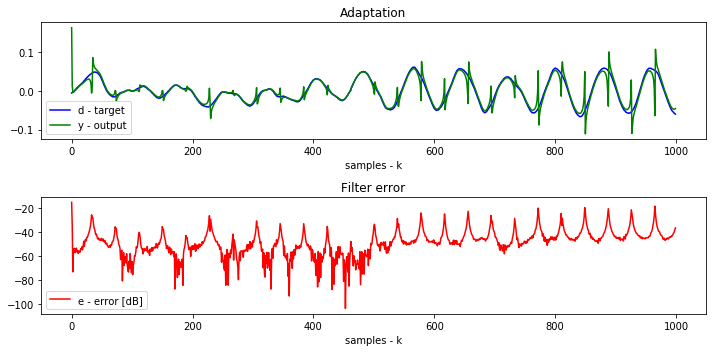

In [0]:
!pip install padasip
import numpy as np
import matplotlib.pylab as plt
import padasip as pa 

# creation of data
N = len(auxu)
x = np.random.normal(0, 1, (N, 1)) # input matrix

d = np.random.normal(0, 1, (N, 1)) # input matrix
for i in range(len(x)):
    x[i] = auxu[i]
    d[i] = auxd[i]
f = pa.filters.FilterRLS(n=1, mu=0.1, w="random")
y, e, w = f.run(d, x)

#show results
plt.figure(figsize=(10,5))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(d,"b", label="d - target")
plt.plot(y,"g", label="y - output");plt.legend()
plt.subplot(212);plt.title("Filter error");plt.xlabel("samples - k")
plt.plot(10*np.log10(e**2),"r", label="e - error [dB]");plt.legend()
plt.tight_layout()
plt.show()